# Projekt - eksplorując polskich ekonomistów
Nasza praca ma na celu zbadanie najbardziej cytowanych polskich ekonomistów według platformy REPEC.

Zczytuję nazwiska i imiona najbardziej cytowanych polskich ekonomistów według bazy repec ze strony: https://ideas.repec.org/top/top.poland.html. Do tego wykorzystam m.in. pakiet Beautiful Soup. 
Z tej strony otrzymam dwie tabele zawierające:
* imię i nazwisko ekonomisty;
* instytucję, do której jest afiliowany;
* link do jego strony na https://ideas.repec.org;
* unikalne ID wspólne dla całej sieci REPEC;
* numer rankingowy;
* 'score', czyli wyliczoną przez REPEC statystykę stanowiącą o jakości naukowca; im niższa, tym lepszy ekonomista.

Jedna z tabel będzie zawierać najbardziej cytowanych polskich ekonomistów wszech czasów, a druga tych najbardziej cytowanych w ostatnich 10 latach. Na dalszym etapie połączymy obie tabele.
Z powyższej strony kluczową informacją będzie dla mnie ID. Wykorzystam je później, aby pobrać dane o cytowaniach, publikacjach itp., które są dostępne na stronie https://citec.repec.org/p/index.html.

### Zatem zaczynamy!
Najpierw ładuję potrzebne biblioteki

In [9]:
import requests  # do wczytania linków
import re  # do regular expressions i operacji na stringach
from bs4 import BeautifulSoup  # do web scrapowania
import pandas as pd  # do tabel (data frame)
import numpy as np  # do manipulacji danych 
import seaborn as sb  #wizualizacja danych
import matplotlib

Teraz otwieram odpowiednią stornę w Pythonie oraz wczytuję obiekt Beautiful Soup.

In [2]:
r = requests.get('https://ideas.repec.org/top/top.poland.html')
soup = BeautifulSoup(r.text, 'html.parser')

Interesują mnie najpierw najbardziej cytowani autorzy ze wszystkich lat. Dane o nich znajdują się w poniższym fragmencie kodu html:
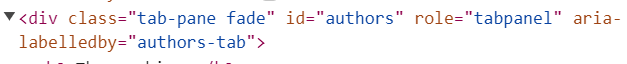
Wiem zatem, że muszę odwołać się do obiektu, którego id="authors". Dane o ekonomistach są umieszczone w tabeli. Aby jednak wczytać linki z tabeli, muszę znaleźć wszystkie fragmenty kodu html zapisane jako 'a', a w nich te, gdzie znajduje się wyrażenie 'href'. Dokonam tego poniższą funkcją.

In [3]:
links = soup.find(id='authors').find_all(
    "a")  # Otrzymuję obiekt ze wszystkimi fragmentami kodu '<a>...</a>' w obszarze o żądanym id
liczba = 0  # potrzebna zmienna do pętli while

# Teraz tworzę pustę ramkę danych do przechowania wyników
df_linki = pd.DataFrame()
# Teraz funkcja while. Przestanie chodzić jeśli przeiteruje po wszystkich linijkach kodu html
while liczba < len(links):
    item = links[liczba]  # pojedynczy fragment kodu
    word = str(item.get('href'))  # link zapisany jako string -> przyda się poniżej
    regexp = re.compile(r'^/')  # regular expression, które mówi, że ciąg znaków zaczyna się od '/'
    # Jeśli brak linku, to przechodzę dalej
    if item.get('href') == None:
        pass
    # sprawdzam czy link zaczyna się od '/'. Jeśli tak, to jest to link do osoby i proceduję dalej. Linki do instytucji pomijam.
    elif regexp.search(word):
        author_link = item.get('href')  # Zczytuję sam link
        author_id = re.sub(r'.html', '', word)
        author_id = re.sub(r'/\w/', '', author_id)  # W tych dwóch linijkach z linku wyciągam ID
        author = item.get_text()  # Zczytuję imię i nazwisko
        # Powyższe dane zapisuję w tymczasowej tabeli
        df_temp = pd.DataFrame({
            'Autor': [author],
            'ID': [author_id],
            'Strona_Ideas': [author_link]
        })
        # Tymczasową tabelę łączę z tabelą na wszystkie wyniki
        df_linki = pd.concat([df_linki, df_temp])
    liczba += 1
    # Dodatkowy warunek, gdyby coś z pętlą while się popsuło
    if liczba > len(links):
        print("Chyba zagapiliśmy się z tolerancją ... przerywamy.")
        break

# Zmieniam indkesy wierszy, żeby były od 0 do 184. Potrzebne do późniejszego połączenia z tabelą zawierającą instytucje
df_linki.index = range(len(df_linki.index))
df_linki.head(10)  # pierwsze 10 obserwacji

,Autor,ID,Strona_Ideas
0,Oded Stark,pst393,/f/pst393.html
1,Rafal Weron,pwe42,/e/pwe42.html
2,Marcin Kolasa,pko253,/f/pko253.html
3,Mikolaj Czajkowski,pcz11,/e/pcz11.html
4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html
5,Michal Wiktor Krawczyk,pkr96,/e/pkr96.html
6,Jakub Growiec,pgr106,/e/pgr106.html
7,Michal Rubaszek,pru76,/e/pru76.html
8,Jacek Osiewalski,pos80,/e/pos80.html
9,Joanna Tyrowicz,pty6,/e/pty6.html


Teraz wczytam tabelę z powyższej strony za pomocą pandas. Umożliwi mi to łatwe odczytanie instytucji, w których pracują ekonomiści.

In [4]:
df_inst = pd.read_html("https://ideas.repec.org/top/top.poland.html")[3]
df_inst.sample(10)  # przykładowe 10 obserwacji

,Rank,W.Rank,Author,Score
139,140,[137],"Piotr Wojcik Wydział Nauk Ekonomicznych, Uniwe...",134.57
134,135,[152],"Anna Sznajderska Instytut Ekonometrii, Szkoła ...",128.57
93,94,[110],Maciej Albinowski Instytut Badań Strukturalnyc...,92.36
84,85,[107],Katarzyna Zawalinska Instytut Rozwoju Wsi i Ro...,86.17
18,19,[35],"Andrzej Nowak Wydział Matematyki, Informatyki ...",25.36
137,138,[163],Sylwester Kozak Katedra Ekonomii i Polityki Go...,132.38
150,151,[140],"Pawel Kaczmarczyk Wydział Nauk Ekonomicznych, ...",146.88
132,133,[128],Malgorzata Iwanicz-Drozdowska Szkoła Główna Ha...,127.24
60,61,[72],"Wojciech Hardy Instytut Badań Strukturalnych, ...",65.47
144,145,[51],Mario Arturo Ruiz Estrada Akademia Ekonomiczno...,138.58


Teraz połączę obie tabele. W obu z nich obserwacje są w tej samej kolejności.

In [5]:
df_merged = pd.concat([df_linki, df_inst], axis=1)
df_merged.tail(10)  # wyświetlę ostatnie 10 obserwacji

,Autor,ID,Strona_Ideas,Rank,W.Rank,Author,Score
175,Syed Anees Haider Zaidi,pza436,/f/pza436.html,176,[79],Syed Anees Haider Zaidi Wydział Nauk Ekonomicz...,173.39
176,Joanna Bruzda,pbr449,/f/pbr449.html,177,[200],Joanna Bruzda Wydział Nauk Ekonomicznych i Zar...,174.17
177,Marcin Faldzinski,pfa290,/f/pfa290.html,178,[208],Marcin Faldzinski Wydział Nauk Ekonomicznych i...,177.33
178,Jan Sladkowski,psl3,/e/psl3.html,179,[194],"Jan Sladkowski Ekonofizyka, Uniwersytet Slaski...",177.46
179,Lukasz K. Kozlowski,pko492,/f/pko492.html,180,[230],Lukasz K. Kozlowski Szkoła Główna Handlowa w W...,177.72
180,Wioleta Kucharska,pku368,/f/pku368.html,181,[195],Wioleta Kucharska Wydział Zarządzania i Ekonom...,177.80
181,Iraj Hashi,pha727,/f/pha727.html,182,[68],Iraj Hashi CASE-Center for Social and Economic...,177.84
182,Alexander Shapoval,psh760,/f/psh760.html,183,[217],Alexander Shapoval,178.93
183,Michal Brzozowski,pbr427,/f/pbr427.html,184,[209],"Michal Brzozowski Wydział Nauk Ekonomicznych, ...",179.07
184,Juliusz Jerzy Jablecki,pja418,/f/pja418.html,185,[227],Juliusz Jerzy Jablecki Wydział Nauk Ekonomiczn...,181.45


Teraz z kolumny 'Author' usunę imię i nazwisko, a kolumnę nazwę 'Instytucja'. Aby to zrobić zacznę od zamiany podwójnej spacji między imieniem i nazwiskiem na pojedynczą. Ponadto usunę spacje na początku i końcu wyrażenia w kolumnach Autor i Author.

In [6]:
for i in range(len(df_merged)):
    df_merged.iloc[i, 0] = re.sub(re.compile('  '), ' ', df_merged.Autor[i]).strip()
    df_merged.iloc[i, 5] = df_merged.iloc[i, 5].strip()
df_merged.sample(7)

,Autor,ID,Strona_Ideas,Rank,W.Rank,Author,Score
29,Adam Zaremba,pza419,/f/pza419.html,30,[14],Adam Zaremba Uniwersytet Ekonomiczny w Poznani...,36.63
8,Jacek Osiewalski,pos80,/e/pos80.html,9,[18],Jacek Osiewalski Uniwersytet Ekonomiczny w Kra...,10.63
147,Natalia Nehrebecka,pne161,/e/pne161.html,148,[120],"Natalia Nehrebecka Wydział Nauk Ekonomicznych,...",143.41
27,Jakub Muck,pmu412,/f/pmu412.html,28,[40],"Jakub Muck Katedra Ekonomii Ilościowej, Szkoła...",35.68
52,Anna Malgorzata Bartczak,pba889,/f/pba889.html,53,[67],Anna Malgorzata Bartczak Wydział Nauk Ekonomic...,59.65
124,Ryszard Kokoszczynski,pko306,/f/pko306.html,125,[136],Ryszard Kokoszczynski Wydział Nauk Ekonomiczny...,119.40
4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,[7],Michal Brzoza-Brzezina Katedra Ekonomii Ilości...,7.13


Teraz, mając pojedyczne spacje między imieniem i nazwiskiem, usunę imię i nazwisko z kolumny 'Author', a kolumnę nazwę 'Instytucja'.

In [7]:
# Usuwam imię i nazwisko z instytucji
for i in range(len(df_merged)):
    df_merged.iloc[i, 5] = re.sub(re.compile(df_merged.Autor[i]), '', df_merged.Author[i])
# Zmieniam nazwę kolumny
df_merged.columns.values[5] = "Instytucja"
df_merged.head(12)

,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score
0,Oded Stark,pst393,/f/pst393.html,1,[1],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27
1,Rafal Weron,pwe42,/e/pwe42.html,2,[2],Katedra Badań Operacyjnych i Inteligencji Biz...,2.77
2,Marcin Kolasa,pko253,/f/pko253.html,3,[4],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.37
3,Mikolaj Czajkowski,pcz11,/e/pcz11.html,4,[5],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",6.86
4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,[7],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.13
5,Michal Wiktor Krawczyk,pkr96,/e/pkr96.html,6,[12],Group for Research in Applied Economics (GRAP...,7.18
6,Jakub Growiec,pgr106,/e/pgr106.html,7,[11],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",8.37
7,Michal Rubaszek,pru76,/e/pru76.html,8,[10],"Instytut Ekonometrii, Szkoła Główna Handlowa ...",10.10
8,Jacek Osiewalski,pos80,/e/pos80.html,9,[18],"Uniwersytet Ekonomiczny w Krakowie, Kraków",10.63
9,Joanna Tyrowicz,pty6,/e/pty6.html,10,[9],Group for Research in Applied Economics (GRAP...,13.87


In [8]:
# dodam kolumnę z imieniem
df_merged["Imię"] = df_merged.Autor.map(lambda x: re.search(r'\w* ', x).group().strip())  #\w -> tylko litery
# dodam kolumnę z nazwiskiem
df_merged["Nazwisko"] = df_merged.Autor.map(
    lambda x: re.search(r' .*$', x).group().strip())  #. -> akceptuję dowolne znaki, m.in. myślnik w nazwisku
# dodam kolumnę z płcią
df_merged["Płeć"] = df_merged.Imię.map(lambda x: "K" if re.search(r'\w$', x).group() == "a" else "M")
df_merged

,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,Płeć
0,Oded Stark,pst393,/f/pst393.html,1,[1],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,M
1,Rafal Weron,pwe42,/e/pwe42.html,2,[2],Katedra Badań Operacyjnych i Inteligencji Biz...,2.77,Rafal,Weron,M
2,Marcin Kolasa,pko253,/f/pko253.html,3,[4],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.37,Marcin,Kolasa,M
3,Mikolaj Czajkowski,pcz11,/e/pcz11.html,4,[5],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",6.86,Mikolaj,Czajkowski,M
4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,[7],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.13,Michal,Brzoza-Brzezina,M
...,...,...,...,...,...,...,...,...,...,...
180,Wioleta Kucharska,pku368,/f/pku368.html,181,[195],"Wydział Zarządzania i Ekonomii, Politechnika ...",177.80,Wioleta,Kucharska,K
181,Iraj Hashi,pha727,/f/pha727.html,182,[68],"CASE-Center for Social and Economic Research,...",177.84,Iraj,Hashi,M
182,Alexander Shapoval,psh760,/f/psh760.html,183,[217],,178.93,Alexander,Shapoval,M
183,Michal Brzozowski,pbr427,/f/pbr427.html,184,[209],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",179.07,Michal,Brzozowski,M


Dodaję nowe kolumny do przechowania informacji o cytowaniach itp.

In [9]:
df_merged["H_index"] = ""
df_merged["i10_index"] = ""
df_merged["Cytowania"] = ""
df_merged["Auto_cytowania"] = ""
df_merged["Artykuły"] = ""
df_merged["Papers"] = ""
df_merged["Książki"] = ""
df_merged["Rozdziały"] = ""
df_merged["Lata_działalności"] = ""
df_merged["CitEc_Link"] = ""

df_merged.head()

,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,Płeć,H_index,i10_index,Cytowania,Auto_cytowania,Artykuły,Papers,Książki,Rozdziały,Lata_działalności,CitEc_Link
0,Oded Stark,pst393,/f/pst393.html,1,[1],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,M,,,,,,,,,,
1,Rafal Weron,pwe42,/e/pwe42.html,2,[2],Katedra Badań Operacyjnych i Inteligencji Biz...,2.77,Rafal,Weron,M,,,,,,,,,,
2,Marcin Kolasa,pko253,/f/pko253.html,3,[4],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.37,Marcin,Kolasa,M,,,,,,,,,,
3,Mikolaj Czajkowski,pcz11,/e/pcz11.html,4,[5],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",6.86,Mikolaj,Czajkowski,M,,,,,,,,,,
4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,[7],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.13,Michal,Brzoza-Brzezina,M,,,,,,,,,,


Następnie stworzę dosyć rozbudowaną funkcję, która najpierw sprawdzi, która strona z CitEc faktycznie działa, a potem zczyta z niej informacje o cytowaniach, indeksach, liczbie publikacji itp.

In [10]:
alphabet = list("abcdefghijklmnopqrstuvwxyz")

for j in range(0, len(df_merged)):
    ending = df_merged.loc[j, "ID"]
    run = 1  # zmienna run, która uruchamia poszukiwanie poprawnej strony, gdy==1. Gdy znaleziono, przyjmuje wartość 0

    for letter in alphabet:
        if run == 1:
            address = f"https://citec.repec.org/p/{letter}/{ending}.html"
            page = requests.get(address).content
            soup2 = BeautifulSoup(page, 'html.parser')

            if soup2.title.get_text() == "404 Not Found":
                run = 1
            else:
                run = 0

    df_merged.loc[j, "CitEc_Link"] = address
    # Odczytywanie h-index, i10-index i cytowania
    index_economist = soup2.find(id="mainAutInd")
    index_text = index_economist.get_text() if index_economist else ""

    Hindex = re.sub(r'H index.*', '', index_text)
    i10index = re.sub(r'i10 index.*', '', index_text)
    i10index = re.sub(r'^.*H index', '', i10index)
    citations = re.sub(r'Citations', '', index_text)
    citations = re.sub(r'^.*i10 index', '', citations)

    df_merged.loc[j, "H_index"] = Hindex
    df_merged.loc[j, "i10_index"] = i10index
    df_merged.loc[j, "Cytowania"] = citations

    # Odczytywanie liczby working papers i artykułów
    articles_all = soup2.find(id="mainAutDat")
    pubs = articles_all.get_text() if articles_all else ""

    articles = re.sub(r'Articles.*', '', pubs)
    articles = re.sub(r'^.*Papers', '', articles)
    articles = re.sub(r'^.*Books', '', articles)
    articles = re.sub(r'^.*Chapters', '', articles)

    papers = re.sub(r'^.*Articles', '', pubs)
    papers = re.sub(r'Papers.*', '', papers)
    papers = re.sub(r'^.*Books', '', papers)
    papers = re.sub(r'^.*Chapters', '', papers)

    books = re.sub(r'^.*Articles', '', pubs)
    books = re.sub(r'^.*Papers', '', books)
    books = re.sub(r'Books.*', '', books)
    books = re.sub(r'^.*Chapters', '', books)

    chapters = re.sub(r'^.*Articles', '', pubs)
    chapters = re.sub(r'^.*Papers', '', chapters)
    chapters = re.sub(r'^.*Books', '', chapters)
    chapters = re.sub(r'Chapters.*', '', chapters)

    df_merged.loc[j, "Artykuły"] = articles
    df_merged.loc[j, "Papers"] = papers
    df_merged.loc[j, "Książki"] = books
    df_merged.loc[j, "Rozdziały"] = chapters

    link_element = soup2.select('#mainAutDat > p')
    try:
        opis = link_element[0].get_text()
        activity = re.search(r'^.*\). ', opis).group().strip()
        self_citations = re.sub(r'^.*citations: ', '', opis).strip()
    except IndexError as e:
        activity = "Unknown"
        self_citations = "Unknown"

    df_merged.loc[j, "Auto_cytowania"] = self_citations
    df_merged.loc[j, "Lata_działalności"] = activity

df_merged

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,Płeć,H_index,i10_index,Cytowania,Auto_cytowania,Artykuły,Papers,Książki,Rozdziały,Lata_działalności,CitEc_Link
0,Oded Stark,pst393,/f/pst393.html,1,[1],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,M,32,68,6939,264 (3.67 %),217,276,4,15,47 years (1976 - 2023).,https://citec.repec.org/p/s/pst393.html
1,Rafal Weron,pwe42,/e/pwe42.html,2,[2],Katedra Badań Operacyjnych i Inteligencji Biz...,2.77,Rafal,Weron,M,32,73,3638,155 (4.09 %),62,151,3,3,28 years (1995 - 2023).,https://citec.repec.org/p/w/pwe42.html
2,Marcin Kolasa,pko253,/f/pko253.html,3,[4],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.37,Marcin,Kolasa,M,20,27,1105,55 (4.74 %),44,89,,1,19 years (2004 - 2023).,https://citec.repec.org/p/k/pko253.html
3,Mikolaj Czajkowski,pcz11,/e/pcz11.html,4,[5],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",6.86,Mikolaj,Czajkowski,M,22,36,1071,104 (8.85 %),57,111,1,10,15 years (2008 - 2023).,https://citec.repec.org/p/c/pcz11.html
4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,[7],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.13,Michal,Brzoza-Brzezina,M,14,23,688,56 (7.53 %),29,78,,,21 years (2002 - 2023).,https://citec.repec.org/p/b/pbr47.html
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,Wioleta Kucharska,pku368,/f/pku368.html,181,[195],"Wydział Zarządzania i Ekonomii, Politechnika ...",177.80,Wioleta,Kucharska,K,,,,Unknown,,,,,Unknown,https://citec.repec.org/p/a/pku368.html
181,Iraj Hashi,pha727,/f/pha727.html,182,[68],"CASE-Center for Social and Economic Research,...",177.84,Iraj,Hashi,M,,,,Unknown,,,,,Unknown,https://citec.repec.org/p/a/pha727.html
182,Alexander Shapoval,psh760,/f/psh760.html,183,[217],,178.93,Alexander,Shapoval,M,,,,Unknown,,,,,Unknown,https://citec.repec.org/p/a/psh760.html
183,Michal Brzozowski,pbr427,/f/pbr427.html,184,[209],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",179.07,Michal,Brzozowski,M,,,,Unknown,,,,,Unknown,https://citec.repec.org/p/b/pbr427.html


In [13]:
df_merged.to_csv('Polish_economists_30_12.csv', encoding='utf-8-sig')

## Teraz czytamy drugą tabelę
Pobieramy tabelę z informacjami o cytowanymi ekonomistami z ostatnich 10 lat. Z racji, że poniższy kod będzie analogiczny do tego, co powyżej, to opiszę go zwięźlej.

In [15]:
links10 = soup.find(id='authors10').find_all(
    "a")  # Otrzymuję obiekt ze wszystkimi fragmentami kodu '<a>...</a>' w obszarze o żądanym id
liczba = 0  # potrzebna zmienna do pętli while

# Teraz tworzę pustę ramkę danych do przechowania wyników
df_linki10 = pd.DataFrame()
# Teraz funkcja while. Przestanie chodzić jeśli przeiteruje po wszystkich linijkach kodu html
while liczba < len(links10):
    item = links10[liczba]  # pojedynczy fragment kodu
    word = str(item.get('href'))  # link zapisany jako string -> przyda się poniżej
    regexp = re.compile(r'^/')  # regular expression, które mówi, że ciąg znaków zaczyna się od '/'
    # Jeśli brak linku, to przechodzę dalej
    if item.get('href') == None:
        pass
    # sprawdzam czy link zaczyna się od '/'. Jeśli tak, to jest to link do osoby i proceduję dalej. Linki do instytucji pomijam.
    elif regexp.search(word):
        author_link = item.get('href')  # Zczytuję sam link
        author_id = re.sub(r'.html', '', word)
        author_id = re.sub(r'/\w/', '', author_id)  # W tych dwóch linijkach z linku wyciągam ID
        author = item.get_text()  # Zczytuję imię i nazwisko
        # Powyższe dane zapisuję w tymczasowej tabeli
        df_temp = pd.DataFrame({
            'Autor': [author],
            'ID': [author_id],
            'Strona_Ideas': [author_link]
        })
        # Tymczasową tabelę łączę z tabelą na wszystkie wyniki
        df_linki10 = pd.concat([df_linki10, df_temp])
    liczba += 1
    # Dodatkowy warunek, gdyby coś z pętlą while się popsuło
    if liczba > len(links10):
        print("Chyba zagapiliśmy się z tolerancją ... przerywamy.")
        break

# Zmieniam indkesy wierszy. Potrzebne do późniejszego połączenia z tabelą zawierającą instytucje
df_linki10.index = range(len(df_linki10.index))
df_linki10.head(10)  # pierwsze 10 obserwacji

,Autor,ID,Strona_Ideas
0,Rafal Weron,pwe42,/e/pwe42.html
1,Mikolaj Czajkowski,pcz11,/e/pcz11.html
2,Marcin Kolasa,pko253,/f/pko253.html
3,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html
4,Michal Rubaszek,pru76,/e/pru76.html
5,Katarzyna Maciejowska,pma1510,/f/pma1510.html
6,Oded Stark,pst393,/f/pst393.html
7,Piotr Dworczak,pdw12,/e/pdw12.html
8,Joanna Tyrowicz,pty6,/e/pty6.html
9,Jakub Nowotarski,pno175,/e/pno175.html


In [17]:
# wczytywanie kolejnej tabeli z powyższej strony za pomocą pandas
df_inst10 = pd.read_html("https://ideas.repec.org/top/top.poland.html")[4]
# łączenie tabeli
df_merged10 = pd.concat([df_linki10, df_inst10], axis=1)
# Przetworzenie kolumny "Intytucja", która jeszcze tutaj nazywa się 'Autor'
for i in range(len(df_merged10)):
    df_merged10.iloc[i, 0] = re.sub(re.compile('  '), ' ', df_merged10.Autor[i]).strip()
    df_merged10.iloc[i, 5] = df_merged10.iloc[i, 5].strip()
# Usuwam imię i nazwisko z instytucji
for i in range(len(df_merged10)):
    df_merged10.iloc[i, 5] = re.sub(re.compile(df_merged10.Autor[i]), '', df_merged10.Author[i])
# Zmieniam nazwę kolumny
df_merged10.columns.values[5] = "Instytucja"
# Dodam kolumnę z imieniem
df_merged10["Imię"] = df_merged10.Autor.map(lambda x: re.search(r'\w* ', x).group().strip())  #\w -> tylko litery
# Dodam kolumnę z nazwiskiem
df_merged10["Nazwisko"] = df_merged10.Autor.map(
    lambda x: re.search(r' .*$', x).group().strip())  #. -> akceptuję dowolne znaki, m.in. myślnik w nazwisku
# Dodam kolumnę z płcią
df_merged10["Płeć"] = df_merged10.Imię.map(lambda x: "K" if re.search(r'\w$', x).group() == "a" else "M")
# Dodam kolejne kolumny
df_merged10["H_index"] = ""
df_merged10["i10_index"] = ""
df_merged10["Cytowania"] = ""
df_merged10["Auto_cytowania"] = ""
df_merged10["Artykuły"] = ""
df_merged10["Papers"] = ""
df_merged10["Książki"] = ""
df_merged10["Rozdziały"] = ""
df_merged10["Lata_działalności"] = ""
df_merged10["CitEc_Link"] = ""

df_merged10.head()

,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,Płeć,H_index,i10_index,Cytowania,Auto_cytowania,Artykuły,Papers,Książki,Rozdziały,Lata_działalności,CitEc_Link
0,Rafal Weron,pwe42,/e/pwe42.html,1,[1],Katedra Badań Operacyjnych i Inteligencji Biz...,2.19,Rafal,Weron,M,,,,,,,,,,
1,Mikolaj Czajkowski,pcz11,/e/pcz11.html,2,[2],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",3.49,Mikolaj,Czajkowski,M,,,,,,,,,,
2,Marcin Kolasa,pko253,/f/pko253.html,3,[4],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.59,Marcin,Kolasa,M,,,,,,,,,,
3,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,4,[13],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.79,Michal,Brzoza-Brzezina,M,,,,,,,,,,
4,Michal Rubaszek,pru76,/e/pru76.html,5,[8],"Instytut Ekonometrii, Szkoła Główna Handlowa ...",8.22,Michal,Rubaszek,M,,,,,,,,,,


In [18]:
for j in range(0, len(df_merged10)):
    ending = df_merged10.loc[j, "ID"]
    run = 1  # zmienna run, która uruchamia poszukiwanie poprawnej strony, gdy==1. Gdy znaleziono, przyjmuje wartość 0

    for letter in alphabet:
        if run == 1:
            address = f"https://citec.repec.org/p/{letter}/{ending}.html"
            page = requests.get(address).content
            soup2 = BeautifulSoup(page, 'html.parser')

            if soup2.title.get_text() == "404 Not Found":
                run = 1
            else:
                run = 0

    df_merged10.loc[j, "CitEc_Link"] = address
    # Odczytywanie h-index, i10-index i cytowania
    index_economist = soup2.find(id="mainAutInd")
    index_text = index_economist.get_text() if index_economist else ""

    Hindex = re.sub(r'H index.*', '', index_text)
    i10index = re.sub(r'i10 index.*', '', index_text)
    i10index = re.sub(r'^.*H index', '', i10index)
    citations = re.sub(r'Citations', '', index_text)
    citations = re.sub(r'^.*i10 index', '', citations)

    df_merged10.loc[j, "H_index"] = Hindex
    df_merged10.loc[j, "i10_index"] = i10index
    df_merged10.loc[j, "Cytowania"] = citations

    # Odczytywanie liczby working papers i artykułów
    articles_all = soup2.find(id="mainAutDat")
    pubs = articles_all.get_text() if articles_all else ""

    articles = re.sub(r'Articles.*', '', pubs)
    articles = re.sub(r'^.*Papers', '', articles)
    articles = re.sub(r'^.*Books', '', articles)
    articles = re.sub(r'^.*Chapters', '', articles)

    papers = re.sub(r'^.*Articles', '', pubs)
    papers = re.sub(r'Papers.*', '', papers)
    papers = re.sub(r'^.*Books', '', papers)
    papers = re.sub(r'^.*Chapters', '', papers)

    books = re.sub(r'^.*Articles', '', pubs)
    books = re.sub(r'^.*Papers', '', books)
    books = re.sub(r'Books.*', '', books)
    books = re.sub(r'^.*Chapters', '', books)

    chapters = re.sub(r'^.*Articles', '', pubs)
    chapters = re.sub(r'^.*Papers', '', chapters)
    chapters = re.sub(r'^.*Books', '', chapters)
    chapters = re.sub(r'Chapters.*', '', chapters)

    df_merged10.loc[j, "Artykuły"] = articles
    df_merged10.loc[j, "Papers"] = papers
    df_merged10.loc[j, "Książki"] = books
    df_merged10.loc[j, "Rozdziały"] = chapters

    link_element = soup2.select('#mainAutDat > p')
    try:
        opis = link_element[0].get_text()
        activity = re.search(r'^.*\). ', opis).group().strip()
        self_citations = re.sub(r'^.*citations: ', '', opis).strip()
    except IndexError as e:
        activity = "Unknown"
        self_citations = "Unknown"

    df_merged10.loc[j, "Auto_cytowania"] = self_citations
    df_merged10.loc[j, "Lata_działalności"] = activity

df_merged10

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,Płeć,H_index,i10_index,Cytowania,Auto_cytowania,Artykuły,Papers,Książki,Rozdziały,Lata_działalności,CitEc_Link
0,Rafal Weron,pwe42,/e/pwe42.html,1,[1],Katedra Badań Operacyjnych i Inteligencji Biz...,2.19,Rafal,Weron,M,32,73,3638,155 (4.09 %),62,151,3,3,28 years (1995 - 2023).,https://citec.repec.org/p/w/pwe42.html
1,Mikolaj Czajkowski,pcz11,/e/pcz11.html,2,[2],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",3.49,Mikolaj,Czajkowski,M,22,36,1071,104 (8.85 %),57,111,1,10,15 years (2008 - 2023).,https://citec.repec.org/p/c/pcz11.html
2,Marcin Kolasa,pko253,/f/pko253.html,3,[4],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.59,Marcin,Kolasa,M,20,27,1105,55 (4.74 %),44,89,,1,19 years (2004 - 2023).,https://citec.repec.org/p/k/pko253.html
3,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,4,[13],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.79,Michal,Brzoza-Brzezina,M,14,23,688,56 (7.53 %),29,78,,,21 years (2002 - 2023).,https://citec.repec.org/p/b/pbr47.html
4,Michal Rubaszek,pru76,/e/pru76.html,5,[8],"Instytut Ekonometrii, Szkoła Główna Handlowa ...",8.22,Michal,Rubaszek,M,11,17,545,42 (7.16 %),50,43,,2,21 years (2002 - 2023).,https://citec.repec.org/p/r/pru76.html
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,Aleksander Welfe,pwe261,/f/pwe261.html,181,[188],"Katedra Modeli i Prognoz Ekonometrycznych, Wy...",164.24,Aleksander,Welfe,M,7,5,131,12 (8.39 %),26,5,,2,33 years (1990 - 2023).,https://citec.repec.org/p/w/pwe261.html
181,Joanna Siwinska-Gorzelak,psi449,/f/psi449.html,182,[209],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",164.38,Joanna,Siwinska-Gorzelak,K,4,2,69,1 (1.43 %),11,7,,,21 years (1999 - 2020).,https://citec.repec.org/p/s/psi449.html
182,Pawel Sakowski,psa504,/f/psa504.html,183,[179],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",164.65,Pawel,Sakowski,M,3,2,36,4 (10 %),9,17,,,14 years (2006 - 2020).,https://citec.repec.org/p/s/psa504.html
183,Marta Anna Goetz,pgt6,/e/pgt6.html,184,[174],"Wydział Biznesu i Stosunków Międzynarodowych,...",165.10,Marta,Anna Goetz,K,2,1,23,1 (4.17 %),19,,,1,13 years (2010 - 2023).,https://citec.repec.org/p/g/pgt6.html


In [19]:
df_merged10.to_csv('Polish_economists10_30_12.csv')

### Łączymy obie tabele

In [29]:
df_razem = pd.concat([df_merged, df_merged10])
# Usuwam powtarzające się obserwacje
df_razem = df_razem.drop_duplicates(subset=['Autor', "ID"])
# Odświeżam indeks
df_razem.index = range(len(df_razem.index))
df_razem

,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,Płeć,H_index,i10_index,Cytowania,Auto_cytowania,Artykuły,Papers,Książki,Rozdziały,Lata_działalności,CitEc_Link
0,Oded Stark,pst393,/f/pst393.html,1,[1],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,M,32,68,6939,264 (3.67 %),217,276,4,15,47 years (1976 - 2023).,https://citec.repec.org/p/s/pst393.html
1,Rafal Weron,pwe42,/e/pwe42.html,2,[2],Katedra Badań Operacyjnych i Inteligencji Biz...,2.77,Rafal,Weron,M,32,73,3638,155 (4.09 %),62,151,3,3,28 years (1995 - 2023).,https://citec.repec.org/p/w/pwe42.html
2,Marcin Kolasa,pko253,/f/pko253.html,3,[4],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.37,Marcin,Kolasa,M,20,27,1105,55 (4.74 %),44,89,,1,19 years (2004 - 2023).,https://citec.repec.org/p/k/pko253.html
3,Mikolaj Czajkowski,pcz11,/e/pcz11.html,4,[5],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",6.86,Mikolaj,Czajkowski,M,22,36,1071,104 (8.85 %),57,111,1,10,15 years (2008 - 2023).,https://citec.repec.org/p/c/pcz11.html
4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,[7],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.13,Michal,Brzoza-Brzezina,M,14,23,688,56 (7.53 %),29,78,,,21 years (2002 - 2023).,https://citec.repec.org/p/b/pbr47.html
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,Arkadiusz Jedrzejewski,pjd1,/e/pjd1.html,178,[207],Katedra Badań Operacyjnych i Inteligencji Biz...,161.29,Arkadiusz,Jedrzejewski,M,3,1,43,2 (4.44 %),4,5,,,6 years (2015 - 2021).,https://citec.repec.org/p/j/pjd1.html
218,Henryk Wojtaszek Sr.,pwo314,/f/pwo314.html,179,[160],"Wydział Zarządzania i Dowodzenia, Akademia Szt...",161.52,Henryk,Wojtaszek Sr.,M,4,2,50,13 (20.63 %),24,,,,2 years (2019 - 2021).,https://citec.repec.org/p/w/pwo314.html
219,Piotr Spiewanowski,ppi491,/f/ppi491.html,180,[201],"Instytut Nauk Ekonomicznych, Polska Akademia ...",163.29,Piotr,Spiewanowski,M,2,1,28,2 (6.67 %),4,7,,,7 years (2016 - 2023).,https://citec.repec.org/p/p/ppi491.html
220,Pawel Sakowski,psa504,/f/psa504.html,183,[179],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",164.65,Pawel,Sakowski,M,3,2,36,4 (10 %),9,17,,,14 years (2006 - 2020).,https://citec.repec.org/p/s/psa504.html


Sprawdzę ponownie obserwacje, których wcześniej nie dało się odczytać. Może z innego IP będę w stanie pobrać brakujące informacje.

In [30]:
for j in range(0, len(df_razem)):
    ending = df_razem.loc[j, "ID"]
    run = 1  # zmienna run, która uruchamia poszukiwanie poprawnej strony, gdy==1. Gdy znaleziono, przyjmuje wartość 0
    if df_razem.loc[j, "Auto_cytowania"] == "Unknown":

        for letter in alphabet:
            if run == 1:
                address = f"https://citec.repec.org/p/{letter}/{ending}.html"
                page = requests.get(address).content
                soup2 = BeautifulSoup(page, 'html.parser')

                if soup2.title.get_text() == "404 Not Found":
                    run = 1
                else:
                    run = 0

        df_razem.loc[j, "CitEc_Link"] = address
        # Odczytywanie h-index, i10-index i cytowania
        index_economist = soup2.find(id="mainAutInd")
        index_text = index_economist.get_text() if index_economist else ""

        Hindex = re.sub(r'H index.*', '', index_text)
        i10index = re.sub(r'i10 index.*', '', index_text)
        i10index = re.sub(r'^.*H index', '', i10index)
        citations = re.sub(r'Citations', '', index_text)
        citations = re.sub(r'^.*i10 index', '', citations)

        df_razem.loc[j, "H_index"] = Hindex
        df_razem.loc[j, "i10_index"] = i10index
        df_razem.loc[j, "Cytowania"] = citations

        # Odczytywanie liczby working papers i artykułów
        articles_all = soup2.find(id="mainAutDat")
        pubs = articles_all.get_text() if articles_all else ""

        articles = re.sub(r'Articles.*', '', pubs)
        articles = re.sub(r'^.*Papers', '', articles)
        articles = re.sub(r'^.*Books', '', articles)
        articles = re.sub(r'^.*Chapters', '', articles)

        papers = re.sub(r'^.*Articles', '', pubs)
        papers = re.sub(r'Papers.*', '', papers)
        papers = re.sub(r'^.*Books', '', papers)
        papers = re.sub(r'^.*Chapters', '', papers)

        books = re.sub(r'^.*Articles', '', pubs)
        books = re.sub(r'^.*Papers', '', books)
        books = re.sub(r'Books.*', '', books)
        books = re.sub(r'^.*Chapters', '', books)

        chapters = re.sub(r'^.*Articles', '', pubs)
        chapters = re.sub(r'^.*Papers', '', chapters)
        chapters = re.sub(r'^.*Books', '', chapters)
        chapters = re.sub(r'Chapters.*', '', chapters)

        df_razem.loc[j, "Artykuły"] = articles
        df_razem.loc[j, "Papers"] = papers
        df_razem.loc[j, "Książki"] = books
        df_razem.loc[j, "Rozdziały"] = chapters

        link_element = soup2.select('#mainAutDat > p')
        try:
            opis = link_element[0].get_text()
            activity = re.search(r'^.*\). ', opis).group().strip()
            self_citations = re.sub(r'^.*citations: ', '', opis).strip()
        except IndexError as e:
            activity = "Unknown"
            self_citations = "Unknown"

        df_razem.loc[j, "Auto_cytowania"] = self_citations
        df_razem.loc[j, "Lata_działalności"] = activity

df_razem

,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,Płeć,H_index,i10_index,Cytowania,Auto_cytowania,Artykuły,Papers,Książki,Rozdziały,Lata_działalności,CitEc_Link
0,Oded Stark,pst393,/f/pst393.html,1,[1],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,M,32,68,6939,264 (3.67 %),217,276,4,15,47 years (1976 - 2023).,https://citec.repec.org/p/s/pst393.html
1,Rafal Weron,pwe42,/e/pwe42.html,2,[2],Katedra Badań Operacyjnych i Inteligencji Biz...,2.77,Rafal,Weron,M,32,73,3638,155 (4.09 %),62,151,3,3,28 years (1995 - 2023).,https://citec.repec.org/p/w/pwe42.html
2,Marcin Kolasa,pko253,/f/pko253.html,3,[4],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.37,Marcin,Kolasa,M,20,27,1105,55 (4.74 %),44,89,,1,19 years (2004 - 2023).,https://citec.repec.org/p/k/pko253.html
3,Mikolaj Czajkowski,pcz11,/e/pcz11.html,4,[5],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",6.86,Mikolaj,Czajkowski,M,22,36,1071,104 (8.85 %),57,111,1,10,15 years (2008 - 2023).,https://citec.repec.org/p/c/pcz11.html
4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,[7],"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.13,Michal,Brzoza-Brzezina,M,14,23,688,56 (7.53 %),29,78,,,21 years (2002 - 2023).,https://citec.repec.org/p/b/pbr47.html
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,Arkadiusz Jedrzejewski,pjd1,/e/pjd1.html,178,[207],Katedra Badań Operacyjnych i Inteligencji Biz...,161.29,Arkadiusz,Jedrzejewski,M,3,1,43,2 (4.44 %),4,5,,,6 years (2015 - 2021).,https://citec.repec.org/p/j/pjd1.html
218,Henryk Wojtaszek Sr.,pwo314,/f/pwo314.html,179,[160],"Wydział Zarządzania i Dowodzenia, Akademia Szt...",161.52,Henryk,Wojtaszek Sr.,M,4,2,50,13 (20.63 %),24,,,,2 years (2019 - 2021).,https://citec.repec.org/p/w/pwo314.html
219,Piotr Spiewanowski,ppi491,/f/ppi491.html,180,[201],"Instytut Nauk Ekonomicznych, Polska Akademia ...",163.29,Piotr,Spiewanowski,M,2,1,28,2 (6.67 %),4,7,,,7 years (2016 - 2023).,https://citec.repec.org/p/p/ppi491.html
220,Pawel Sakowski,psa504,/f/psa504.html,183,[179],"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",164.65,Pawel,Sakowski,M,3,2,36,4 (10 %),9,17,,,14 years (2006 - 2020).,https://citec.repec.org/p/s/psa504.html


In [ ]:
df_razem.to_csv('Polish_all_economists_30_12.csv')

 ## Analiza Deskryptywna i wizualizacja danych
 W dalszej części wykorzystujemy zebrane dane do wizualizacji informacji o polskich ekonomistach. Zasadniczo ta część ma na celu atrakcyjne zaprezentowanie danych, przed rozpoczęciem szerszej analizy empirycznej. 
 Przy pomocy narzędzi wizualizacji danych, spróbujemy odpowiedzieć na następujące pytania:
* Czy pozycja ekonomistek jest znacząco niższa niż ekonomistów? Jeśli tak, to czy są instytucje, które szerzej promują równościowy rozwój mężczyzn i kobiet?
* Czy na przełomie lat obserwujemy zmianę w zakresie preferowanych form upubliczniania wiedzy? Czy starsi autorzy publikowali więcej książek, a młodsi artykułów?
* Czy autorzy, których nazwisko ma charakterystyczny dla języka polskiego wydźwięk, uzyskali mniej cytowań? 
 
 

In [26]:
# Wczytanie pakietów do wizualizacji i analizy statystycznej 
import matplotlib.pyplot as plt
import seaborn as sn
import re
import pandas as pd
import plotly.express as px
# Wykresy widoczne w notatniku
%matplotlib inline

Na początku musimy wyczyścić dane pobrane z Repec. Wykorzystamy do tego funkcję typu regular expressions, która poszukuje pewnych regularności w tekście. 

In [11]:
# Wczytanie danych
data = pd.read_csv("Polish_all_economists_30_12.csv")
data = data.dropna(subset=["Cytowania", "Auto_cytowania"])
# Zamiana niewygodnych zmiennych na odpowiednie do analizy 
# W.rank [digit] -> digit
data['W.Rank'] = data['W.Rank'].str.extract('(\d+)').astype(int)
# Auto_cytowania f (f%) -> auto_cytowania_n - f; auto_cytowania_p - f
data['Auto_cytowania_n'] = data['Auto_cytowania'].str.extract(r'(\d+\s)').astype(float)
data['Auto_cytowania_p'] = (data['Auto_cytowania_n'] / (data['Cytowania'] + data['Auto_cytowania_n']) * 100).round(2)
#Lata_dzialalnosci f years (f - f) -> lata_dzialalnosci_n - f; rok_start - f
data['lata_dzialalnosci_n'] = data['Lata_działalności'].str.extract(r'(\d+)').astype(int)
data['rok_start'] = data['Lata_działalności'].str.extract(r'\((\d{4})', expand=False).astype(int)
data['rok_koniec'] = data['rok_start'] + data['lata_dzialalnosci_n']
data['active'] = np.where(data['rok_koniec'] == 2023, 'Y', 'N')

# Wyświetl bazę danych 
data


,Unnamed: 0,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,...,Książki,Rozdziały,Lata_działalności,CitEc_Link,Auto_cytowania_n,Auto_cytowania_p,lata_dzialalnosci_n,rok_start,rok_koniec,active
0,0,Oded Stark,pst393,/f/pst393.html,1,1,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,...,4.0,15.0,47 years (1976 - 2023).,https://citec.repec.org/p/s/pst393.html,264.0,3.67,47,1976,2023,Y
1,1,Rafal Weron,pwe42,/e/pwe42.html,2,2,Katedra Badań Operacyjnych i Inteligencji Biz...,2.77,Rafal,Weron,...,3.0,3.0,28 years (1995 - 2023).,https://citec.repec.org/p/w/pwe42.html,155.0,4.09,28,1995,2023,Y
2,2,Marcin Kolasa,pko253,/f/pko253.html,3,4,"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.37,Marcin,Kolasa,...,NaN,1.0,19 years (2004 - 2023).,https://citec.repec.org/p/k/pko253.html,55.0,4.74,19,2004,2023,Y
3,3,Mikolaj Czajkowski,pcz11,/e/pcz11.html,4,5,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",6.86,Mikolaj,Czajkowski,...,1.0,10.0,15 years (2008 - 2023).,https://citec.repec.org/p/c/pcz11.html,104.0,8.85,15,2008,2023,Y
4,4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,7,"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.13,Michal,Brzoza-Brzezina,...,NaN,NaN,21 years (2002 - 2023).,https://citec.repec.org/p/b/pbr47.html,56.0,7.53,21,2002,2023,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,217,Arkadiusz Jedrzejewski,pjd1,/e/pjd1.html,178,207,Katedra Badań Operacyjnych i Inteligencji Biz...,161.29,Arkadiusz,Jedrzejewski,...,NaN,NaN,6 years (2015 - 2021).,https://citec.repec.org/p/j/pjd1.html,2.0,4.44,6,2015,2021,N
218,218,Henryk Wojtaszek Sr.,pwo314,/f/pwo314.html,179,160,"Wydział Zarządzania i Dowodzenia, Akademia Szt...",161.52,Henryk,Wojtaszek Sr.,...,NaN,NaN,2 years (2019 - 2021).,https://citec.repec.org/p/w/pwo314.html,13.0,20.63,2,2019,2021,N
219,219,Piotr Spiewanowski,ppi491,/f/ppi491.html,180,201,"Instytut Nauk Ekonomicznych, Polska Akademia ...",163.29,Piotr,Spiewanowski,...,NaN,NaN,7 years (2016 - 2023).,https://citec.repec.org/p/p/ppi491.html,2.0,6.67,7,2016,2023,Y
220,220,Pawel Sakowski,psa504,/f/psa504.html,183,179,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",164.65,Pawel,Sakowski,...,NaN,NaN,14 years (2006 - 2020).,https://citec.repec.org/p/s/psa504.html,4.0,10.00,14,2006,2020,N


<Axes: xlabel='lata_dzialalnosci_n', ylabel='Cytowania'>

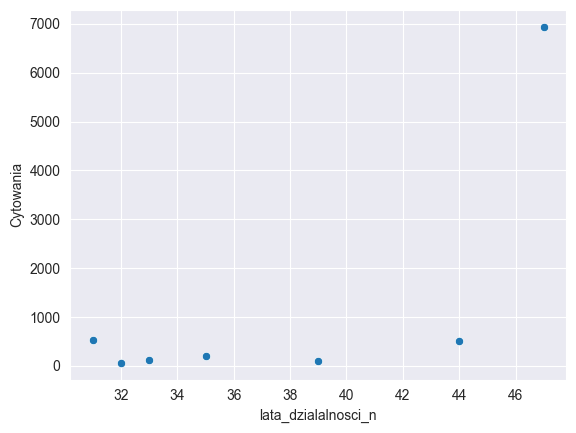

In [12]:
# Podstawowe scatter ploty 
# sn.scatterplot(x = "lata_dzialalnosci_n", y = "Cytowania", data = data)
# Istotny outlier - prof. Oded Stark 
# Wykluczyć prof. Odeda Starka
data_no_stark = data[(data['Cytowania'] < 5000)]
# Brak jasnej zależności - okres działalności a liczba cytowań
# sn.scatterplot(x = "lata_dzialalnosci_n", y = "Cytowania", data = data_no_stark)
# porównanie dla autorów działających przed 1990 a po 1990
data_before = data[(data['rok_start'] <= 1990)]
data_after = data[(data['rok_start'] > 1990)]
sn.scatterplot(x="lata_dzialalnosci_n", y="Cytowania", data=data_before)
# sn.scatterplot(x = "lata_dzialalnosci_n", y = "Cytowania", data = data_after)

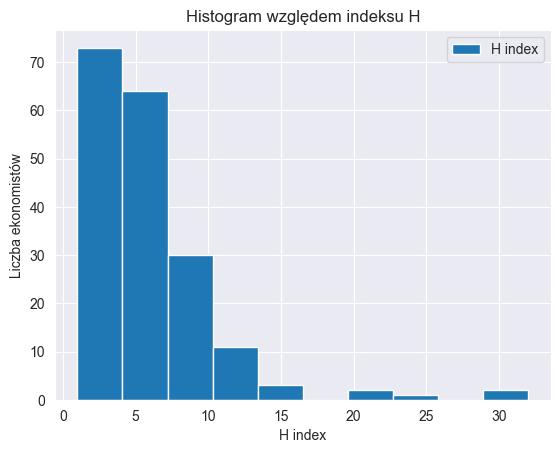

In [13]:
list(data.columns)
#plt.style.use('default')
#plt.style.use('ggplot')

data.H_index.hist(label="H index")
plt.xlabel('H index')
plt.ylabel('Liczba ekonomistów')
plt.title("Histogram względem indeksu H")
plt.legend()
plt.show()

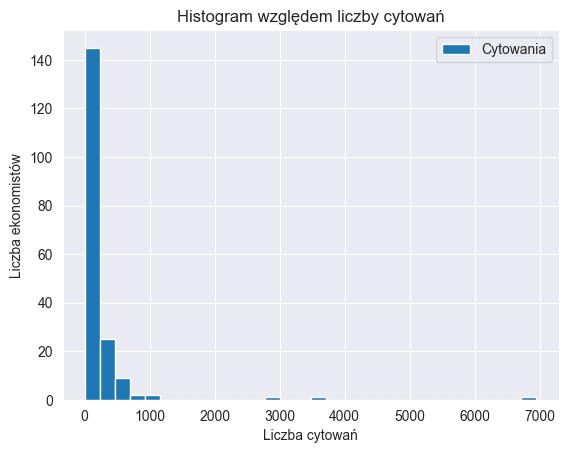

In [14]:
plt.hist(data.Cytowania, bins=30, label="Cytowania")
plt.xlabel('Liczba cytowań')
plt.ylabel('Liczba ekonomistów')
plt.title("Histogram względem liczby cytowań")
plt.legend()
plt.show()

In [15]:
# P1. Pozycja Ekonomistek w porównaniu do ekonomistów
# Dla porównywalności losów, wykorzystujemy porównania w zależności od początku aktywności
# Na tą potrzebę, tworzymy zmienną charakteryzującą dekady rozpoczęcia aktywności naukowej
data["rok_start"].describe()


# min - 1976; max - 2020

# Funckja do opisania dekad 
def rok_decade(rok):
    if 1975 < rok <= 1985:
        return "1975-1985"
    elif 1985 < rok <= 1995:
        return "1985-1995"
    elif 1995 < rok <= 2005:
        return "1995-2005"
    elif 2005 < rok <= 2015:
        return "2005-2015"
    elif 2015 < rok <= 2025:
        return "2015-2025"
    else:
        return "Unknown"


# Przypisanie wartości
data["decade"] = data["rok_start"].apply(rok_decade)


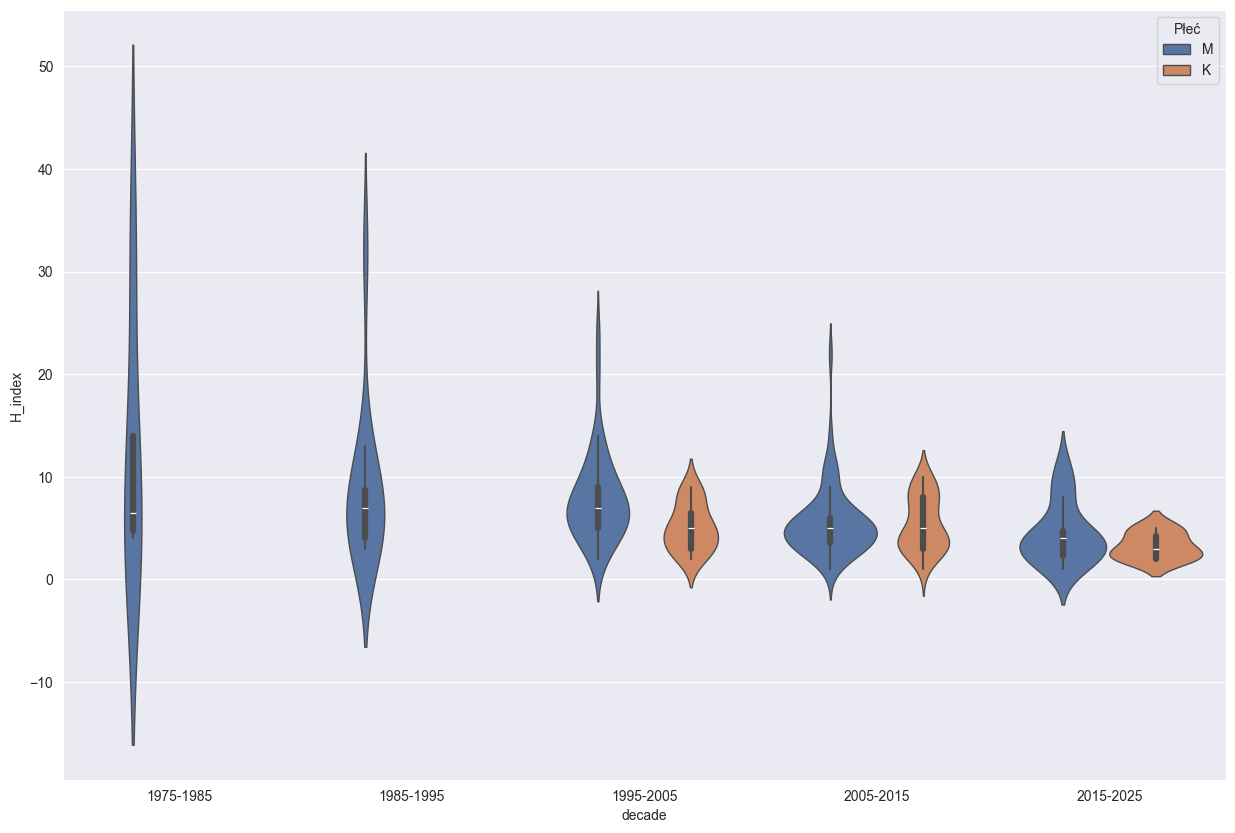

In [16]:
# Wielkość okna


# # Draw a violinplot with a narrower bandwidth than the default
# v_plot = sn.violinplot(data = data, palette = "deep", linewidth = 1, x = 'decade', y = 'H_index', hue = 'Płeć')
# sn.set_style("white")
# sn.set_context("poster", rc= {'font.size':3})
# # Ustawienia ramek
# sn.despine(left = True, bottom = False, offset= True, trim=False)

f = plt.figure(figsize=(15, 10))

with (sn.axes_style("darkgrid")):
    sn.violinplot(data=data, palette="deep", linewidth=1, x='decade', y='H_index', hue='Płeć')





In [17]:
# Aggregacja danych do zbudowania wskaźnika 
x = data["Instytucja"].unique()[30]


# Problemem przy analizie po instytucjach jest zgrupowanie afiliacji
# Ale RePec podaje informacje zgrupowane według wielkości etatu
# Dla uproszczenia, założymy, że to pierwsza instytucja determinuje rozwój
# Zgrupowane instytucje rozdzielone są informacją o miejscowości

# separator = ["Warszawa", "Szczecin", "Wrocław", "Zielona Góra", "Gdańsk", "Poznań", "Kraków", "Łódź", "Toruń", "Olsztyn", "Kielce", "Dąbrowa Górnicza", "Katowice"]
def split_institution(x):
    if isinstance(x, str):
        p = re.split(
            ', Warszawa|, Szczecin|, Wrocław|, Zielona Góra|, Gdańsk|, Poznań|, Kraków|, Łódź|, Toruń|, Olsztyn|, Kielce|, Dąbrowa Górnicza|, Katowice|, Gdansk|, Wroclaw',
            x)
        return p[0]
    else:
        return np.nan

In [18]:
# Apply the function to the "Instytucja" column
data["Instytucja_short"] = data["Instytucja"].apply(split_institution)
data["Instytucja_shorter"] = data["Instytucja_short"].str.split(',').str[-1].str.strip()
data["Instytucja_shorter"] = np.where(pd.isna(data["Instytucja_shorter"]), data["Instytucja_short"],
                                      data["Instytucja_shorter"])
data["Instytucja_shorter"].unique()
# Udało nam się skrócić informację do 32 unikatowych instytucji 

array(['Uniwersytet Warszawski', 'Politechnika Wrocławska',
       'Szkoła Główna Handlowa w Warszawie',
       'Group for Research in Applied Economics (GRAPE)',
       'Instytut Badań Strukturalnych',
       'Centrum Analiz Ekonomicznych (CenEA)',
       'Akademia Finansów i Biznesu Vistula', 'Uniwersytet Zielonogórski',
       'Politechnika Gdańska', 'Polska Akademia Nauk',
       'Akademia Leona Koźmińskiego',
       'Uniwersytet Ekonomiczny w Poznaniu', 'Akademia Górniczo-Hutnicza',
       nan, 'Narodowy Bank Polski', 'Uniwersytet Ekonomiczny w Krakowie',
       'CASE-Center for Social and Economic Research',
       'Akademia Ekonomiczno-Humanistyczna w Warszawie',
       'Uniwersytet Ekonomiczny we Wrocławiu', 'Uniwersytet Łódzki',
       'Uniwersytet Szczecinski',
       'Uniwersytet Mikolaja Kopernika w Toruniu',
       'Universytet Warmi&nacute;sko Mazurski w Olsztynie',
       'Uniwersytet Gdanski', 'Uniwersytet Wroclawski',
       'Uniwersytet Jana Kochanowskiego w Kielcach'

In [19]:
# Data grouping and aggregation
aggs = data.groupby(["Instytucja_shorter", "Płeć"]).agg(
    {'Cytowania': 'median', 'H_index': 'median', 'Auto_cytowania': 'count'}).reset_index()

# Filter based on conditions
both_k_m = aggs.groupby("Instytucja_shorter").agg({'Cytowania': 'count'}).query('Cytowania > 1')
ogr = list(both_k_m.index)
aggs_filtered = aggs[aggs["Instytucja_shorter"].isin(ogr)]

# Pivot the DataFrame into wider form
aggs_wide = aggs_filtered.pivot(index='Instytucja_shorter', columns='Płeć',
                                values=['Cytowania', 'H_index', 'Auto_cytowania'])

# Flatten the multi-level column names
aggs_wide.columns = [' '.join(col).strip() for col in aggs_wide.columns.values]

# Reset the index if needed
aggs_wide = aggs_wide.reset_index()

# Calculate ratios
aggs_wide["Citation_ratio"] = aggs_wide["Cytowania K"] / aggs_wide["Cytowania M"]
aggs_wide["H_index_ratio"] = aggs_wide["H_index K"] / aggs_wide["H_index M"]
aggs_wide["Number_ratio"] = aggs_wide["Auto_cytowania K"] / aggs_wide["Auto_cytowania M"]

# Display the resulting DataFrame
aggs_wide

,Instytucja_shorter,Cytowania K,Cytowania M,H_index K,H_index M,Auto_cytowania K,Auto_cytowania M,Citation_ratio,H_index_ratio,Number_ratio
0,Akademia Finansów i Biznesu Vistula,23.0,362.5,2.0,6.5,1.0,2.0,0.063448,0.307692,0.500000
1,Group for Research in Applied Economics (GRAPE),408.0,241.0,10.0,9.0,1.0,5.0,1.692946,1.111111,0.200000
2,Instytut Badań Strukturalnych,40.0,140.0,5.0,5.0,3.0,3.0,0.285714,1.000000,1.000000
3,Narodowy Bank Polski,87.0,121.0,4.0,4.0,3.0,3.0,0.719008,1.000000,1.000000
4,Politechnika Gdańska,73.0,172.0,4.5,5.0,6.0,1.0,0.424419,0.900000,6.000000
5,Politechnika Wrocławska,268.0,147.0,7.0,5.0,6.0,11.0,1.823129,1.400000,0.545455
6,Polska Akademia Nauk,122.0,63.0,5.0,5.0,3.0,6.0,1.936508,1.000000,0.500000
7,Szkoła Główna Handlowa w Warszawie,32.0,114.0,3.0,6.0,3.0,25.0,0.280702,0.500000,0.120000
8,Uniwersytet Ekonomiczny w Krakowie,137.0,89.0,6.5,5.0,2.0,6.0,1.539326,1.300000,0.333333
9,Uniwersytet Ekonomiczny w Poznaniu,71.5,65.0,3.5,5.0,4.0,3.0,1.100000,0.700000,1.333333


In [20]:
# Plot the three ratios
result_cit = aggs_wide.groupby("Instytucja_shorter").aggregate({'Citation_ratio': 'mean'}).sort_values(
    by="Citation_ratio")
result_h_index = aggs_wide.groupby("Instytucja_shorter").aggregate({'H_index_ratio': 'mean'}).sort_values(
    by="H_index_ratio")
result_number = aggs_wide.groupby("Instytucja_shorter").aggregate({'Number_ratio': 'mean'}).sort_values(
    by="Number_ratio")

result_cit = result_cit.reset_index()
result_h_index = result_h_index.reset_index()
result_number = result_number.reset_index()

In [21]:
from matplotlib import font_manager
from matplotlib.font_manager import fontManager, FontProperties

font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
path = 'C:\\Users\\wojci\\AppData\\Local\\Microsoft\\Windows\\Fonts\\Roboto-Regular.ttf'
fontManager.addfont(path)

prop = FontProperties(fname=path)


C:\Users\wojci\AppData\Local\Temp\ipykernel_35712\3716366886.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt_cit = sn.barplot(x="Instytucja_shorter",
C:\Users\wojci\OneDrive\WSZ\Projekt2\venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\wojci\OneDrive\WSZ\Projekt2\venv\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\wojci\OneDrive\WSZ\Projekt2\venv\Lib\site

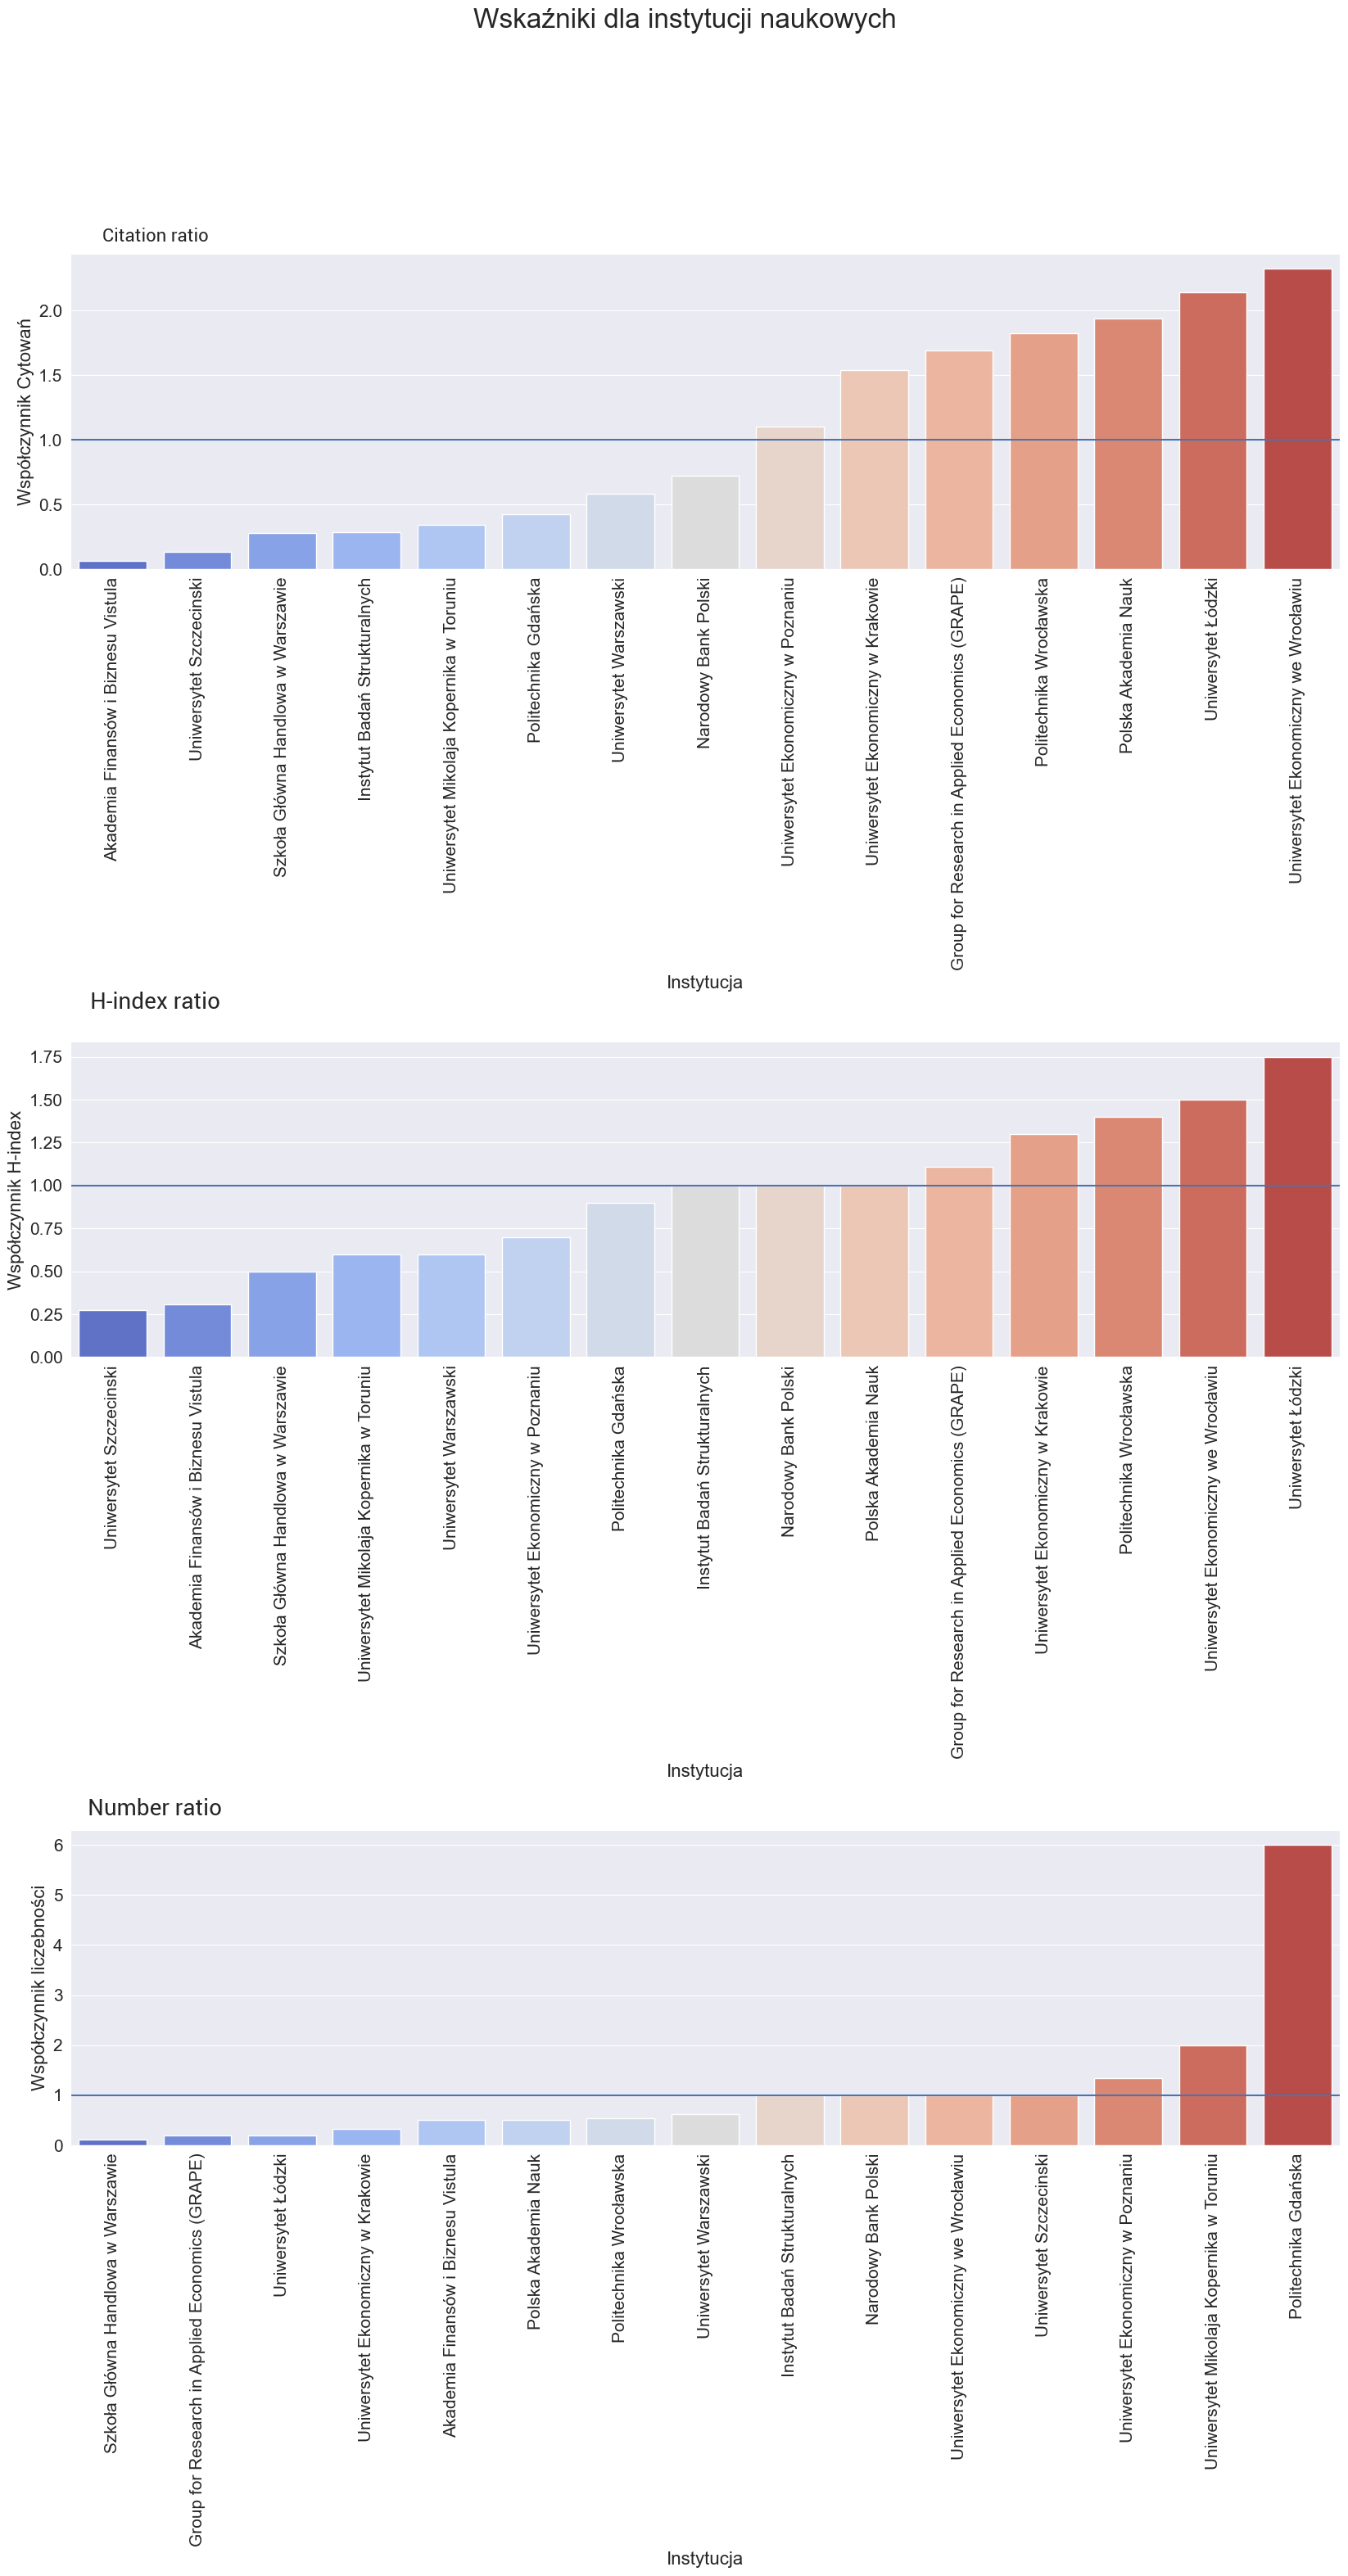

In [22]:
import matplotlib.pyplot as plt  # Import Biblioteki pod rysowanie
import matplotlib.pylab as pylab

# Ustalamy wielkość figury,
fig, axes = plt.subplots(3, 1, figsize=(20, 30), sharex=False)
fig.suptitle('Wskaźniki dla instytucji naukowych', fontsize=24)

# Ustalamy styl figury
sn.set(style="white", font='Roboto', font_scale=1)

# Plot Citation ratio
plt_cit = sn.barplot(x="Instytucja_shorter",
                     y="Citation_ratio",
                     data=aggs_wide,
                     estimator=np.mean,
                     order=result_cit['Instytucja_shorter'],
                     ax=axes[0],
                     palette=sn.color_palette("coolwarm", 15))

# Ustalamy wielkość i obrócenie etykiet na osi OX
plt_cit.tick_params(axis='x', rotation=90, labelsize=15)

# Ustalamy wielkość i obrócenie etykiet na osi OY
plt_cit.tick_params(axis='y', labelsize=15)

# Pozioma linia dla idealnie równego wskaźnika
plt_cit.axhline(y=1)

# Ustalamy tytuły i wielkość tekstu na osiach
plt_cit.set_xlabel("Instytucja", fontsize=16)
plt_cit.set_ylabel("Współczynnik Cytowań", fontsize=16)

# Ustalamy wielkość i charakterystyki dla podytytułów
plt_cit.text(x=0.5, y=2.5, s='Citation ratio', fontsize=16, weight='bold', ha='center', va='bottom')

# Dodajemy odstęp 1.5, aby ułatwić czytanie wykresów
fig.subplots_adjust(hspace=1.5)

# Postępujemy analogicznie dla H_index i Occurences ratio

# Plot H index
plt_h_index = sn.barplot(x="Instytucja_shorter",
                         y="H_index_ratio",
                         data=aggs_wide,
                         estimator=np.mean,
                         order=result_h_index['Instytucja_shorter'],
                         ax=axes[1],
                         palette=sn.color_palette("coolwarm", 15))

plt_h_index.tick_params(axis='x', rotation=90, labelsize=15)
plt_h_index.tick_params(axis='y', labelsize=15)
plt_h_index.set_xlabel("Instytucja", fontsize=16)
plt_h_index.set_ylabel("Współczynnik H-index", fontsize=16)
plt_h_index.set(xlabel="Instytucja", ylabel="Współczynnik H-index")
plt_h_index.axhline(y=1)
plt_h_index.text(x=0.5, y=2, s='H-index ratio', fontsize=20, weight='bold', ha='center', va='bottom')

# Plot Number
plt_number = sn.barplot(x="Instytucja_shorter",
                        y="Number_ratio",
                        data=aggs_wide,
                        estimator=np.mean,
                        order=result_number['Instytucja_shorter'],
                        ax=axes[2],
                        palette=sn.color_palette("coolwarm", 15))

plt_number.tick_params(axis='x', rotation=90, labelsize=15)
plt_number.tick_params(axis='y', labelsize=15)
plt_number.set_xlabel("Instytucja", fontsize=16)
plt_number.set_ylabel("Współczynnik liczebności", fontsize=16)
plt_number.text(x=0.5, y=6.5, s='Number ratio', fontsize=20, weight='bold', ha='center', va='bottom')
plt_number.axhline(y=1)

# Finalnie pokazujemy wspólny wykres.
plt.show()

In [24]:
# Odpowiednio dla każdej z instytucji agregujemy informacje o medianie cytowań i H_index, oraz całkowitej wartości wystąpienia osoby w zestawieniu
# Na tej podstawie rysujemy zależności między równością instytucji, a generalnym wynikiem w zestawieniu

aggs_total = data.groupby(["Instytucja_shorter"]).agg(
    {'Cytowania': 'median', 'H_index': 'median', 'Auto_cytowania': 'count'}).reset_index()
aggs_total = aggs_total[aggs_total["Instytucja_shorter"].isin(ogr)]
aggs_total = aggs_total.merge(aggs_wide, how='left')
aggs_total

,Instytucja_shorter,Cytowania,H_index,Auto_cytowania,Cytowania K,Cytowania M,H_index K,H_index M,Auto_cytowania K,Auto_cytowania M,Citation_ratio,H_index_ratio,Number_ratio
0,Akademia Finansów i Biznesu Vistula,220.0,5.0,3,23.0,362.5,2.0,6.5,1.0,2.0,0.063448,0.307692,0.500000
1,Group for Research in Applied Economics (GRAPE),324.5,9.5,6,408.0,241.0,10.0,9.0,1.0,5.0,1.692946,1.111111,0.200000
2,Instytut Badań Strukturalnych,90.0,5.0,6,40.0,140.0,5.0,5.0,3.0,3.0,0.285714,1.000000,1.000000
3,Narodowy Bank Polski,99.0,4.0,6,87.0,121.0,4.0,4.0,3.0,3.0,0.719008,1.000000,1.000000
4,Politechnika Gdańska,73.0,5.0,7,73.0,172.0,4.5,5.0,6.0,1.0,0.424419,0.900000,6.000000
5,Politechnika Wrocławska,170.0,6.0,17,268.0,147.0,7.0,5.0,6.0,11.0,1.823129,1.400000,0.545455
6,Polska Akademia Nauk,103.0,5.0,9,122.0,63.0,5.0,5.0,3.0,6.0,1.936508,1.000000,0.500000
7,Szkoła Główna Handlowa w Warszawie,107.5,5.5,28,32.0,114.0,3.0,6.0,3.0,25.0,0.280702,0.500000,0.120000
8,Uniwersytet Ekonomiczny w Krakowie,89.0,5.0,8,137.0,89.0,6.5,5.0,2.0,6.0,1.539326,1.300000,0.333333
9,Uniwersytet Ekonomiczny w Poznaniu,65.0,5.0,7,71.5,65.0,3.5,5.0,4.0,3.0,1.100000,0.700000,1.333333


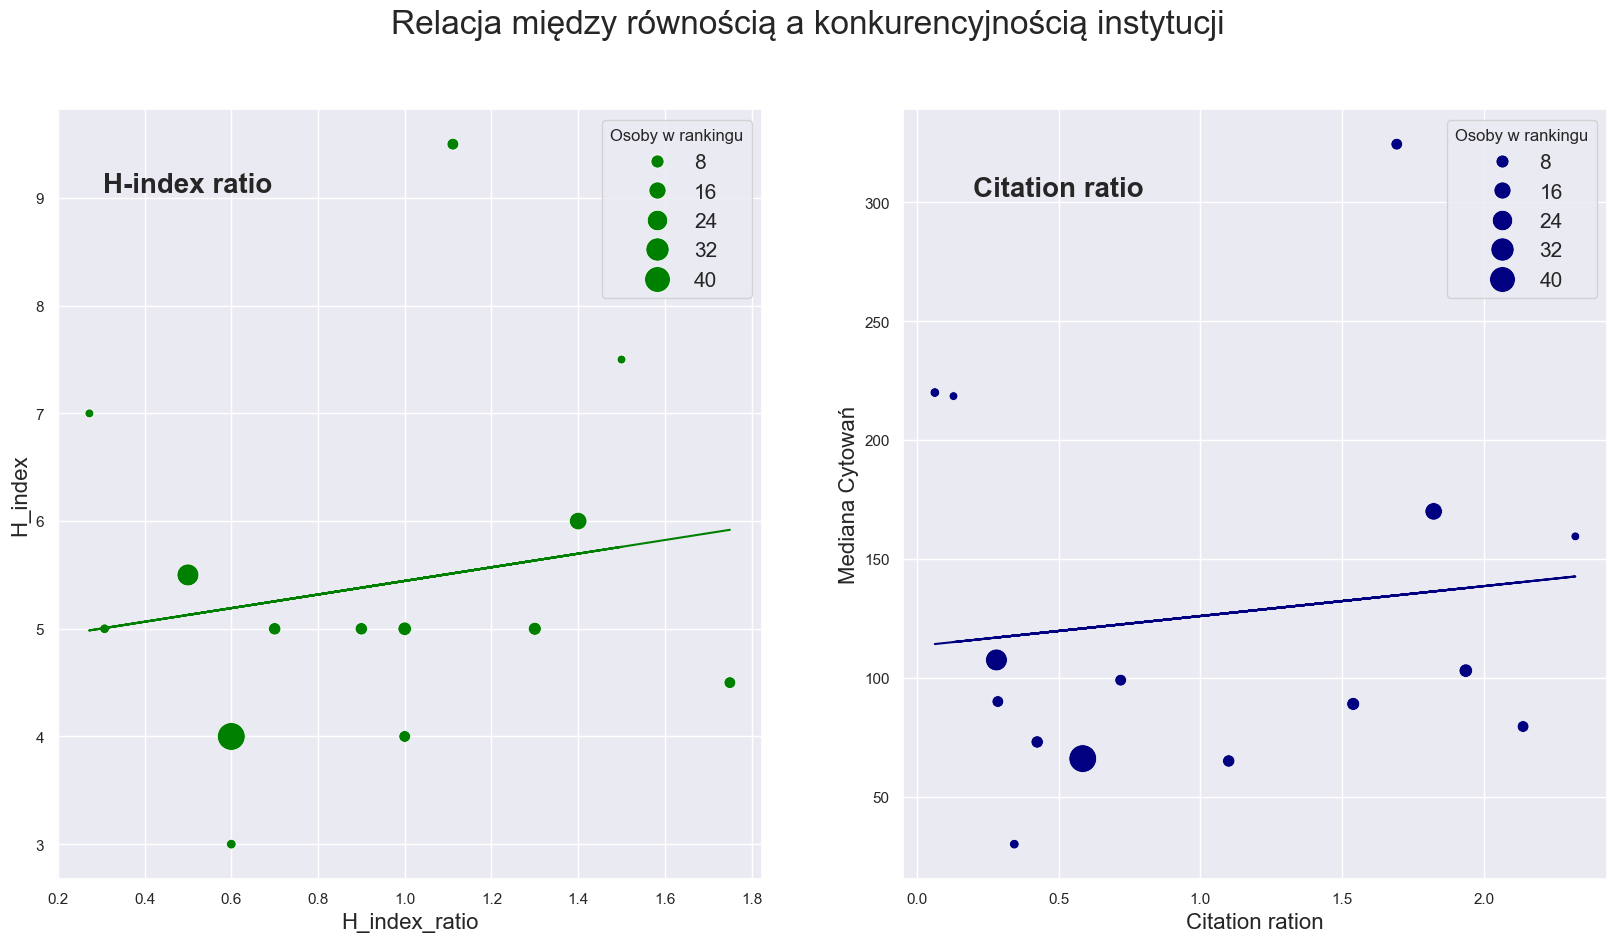

In [29]:
# Ponownie rysujemy, tym razem scatter plots

# Ustalamy wielkość figury,
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex='none')
fig.suptitle('Relacja między równością a konkurencyjnością instytucji', fontsize=24)

# Ustalamy styl figury
sn.set(style="white")
sn.set(font_scale=1)

# Wykres dla H-index
h_index_plt = sn.scatterplot(x="H_index_ratio",
                             y="H_index",
                             ax=axes[0],
                             size="Auto_cytowania",
                             color="green",
                             data=aggs_total,
                             sizes=(40, 400))
m1, b1 = np.polyfit(aggs_total['H_index_ratio'],
                    aggs_total['H_index'], 1)

h_index_plt.plot(aggs_total['H_index_ratio'],
                 m1 * aggs_total['H_index_ratio'] + b1,
                 color="green")
h_index_plt.set_xlabel("H_index_ratio", fontsize=16)
h_index_plt.set_ylabel("H_index", fontsize=16)

h_index_plt.text(x=0.5,
                 y=9,
                 s='H-index ratio',
                 fontsize=20,
                 weight='bold',
                 ha='center',
                 va='bottom')
h_index_plt.legend(title="Osoby w rankingu",
                   fontsize=15,
                   loc="upper right")

# Wykres dla Cytowań
cit_plt = sn.scatterplot(x="Citation_ratio",
                         y="Cytowania",
                         ax=axes[1],
                         sizes=(40, 400),
                         color="navy",
                         size="Auto_cytowania",
                         data=aggs_total)
m2, b2 = np.polyfit(aggs_total['Citation_ratio'],
                    aggs_total['Cytowania'], 1)

cit_plt.plot(aggs_total['Citation_ratio'],
             m2 * aggs_total['Citation_ratio'] + b2,
             color="navy")
cit_plt.set_xlabel("Citation ration", fontsize=16)
cit_plt.set_ylabel("Mediana Cytowań", fontsize=16)

cit_plt.text(x=0.5,
             y=300,
             s='Citation ratio',
             fontsize=20,
             weight='bold',
             ha='center',
             va='bottom')
cit_plt.legend(title="Osoby w rankingu",
               fontsize=15,
               loc='upper right')

plt.show()



In [39]:
import plotly.express as px

# aggs_wide
fig = px.scatter(aggs_total, x = "H_index_ratio", y="H_index",  
                 size='Auto_cytowania', hover_data=['Auto_cytowania'], 
                 marginal_x="histogram", marginal_y="rug",
                 trendline="ols")
fig.show()





In [41]:
aggs_total.to_csv("aggs_total.csv")

C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tigh

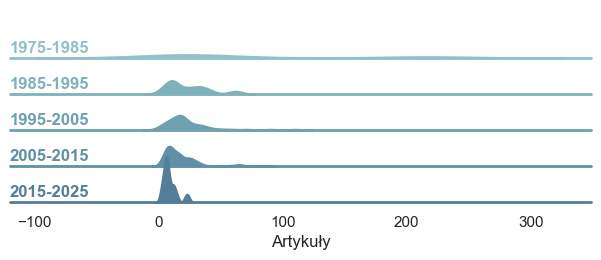

In [46]:
# Istnieją różne tendencje w działalności naukowej
# Artykuły
sn.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal1 = sn.cubehelix_palette(10, rot=-.25, light=.7)
g1 = sn.FacetGrid(data,
                  row="decade",
                  hue="decade",
                  aspect=15,
                  height=.5,
                  palette=pal1)

# Draw the densities in a few steps
g1.map(sn.kdeplot,
       "Artykuły",
       bw_adjust=.5,
       clip_on=False,
       fill=True,
       alpha=1,
       linewidth=1.5)

# passing color=None to refline() uses the hue mapping
g1.refline(y=0,
           linewidth=2,
           linestyle="-",
           color=None,
           clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g1.map(label, "Artykuły")

# Set the subplots to overlap
g1.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g1.set_titles("")
g1.set(yticks=[], ylabel="")
g1.despine(bottom=True, left=True)


C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\wojci\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes he

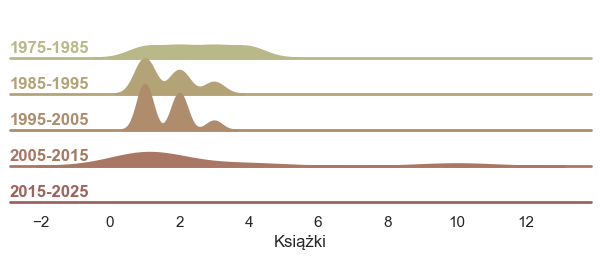

In [47]:
# Książki
sn.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal2 = sn.cubehelix_palette(10, rot=.7, light=.7)
g2 = sn.FacetGrid(data, row="decade", hue="decade", aspect=15, height=.5, palette=pal2)

# Draw the densities in a few steps
g2.map(sn.kdeplot, "Książki",
       bw_adjust=.5,
       clip_on=False,
       fill=True,
       alpha=1,
       linewidth=1.5)

# passing color=None to refline() uses the hue mapping
g2.refline(y=0,
           linewidth=2,
           linestyle="-",
           color=None,
           clip_on=False)
g2.map(label, "Książki")

# Set the subplots to overlap
g2.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g2.set_titles("")
g2.set(yticks=[], ylabel="")
g2.despine(bottom=True, left=True)

## Dane o współpracownikach

Poniżej pobieram dane o współpracownikach ekonomistów korzystając ze strony Citec

In [48]:
df_scraped = pd.read_csv('Polish_all_economists_30_12.csv')
df_scraped = df_scraped.drop(df_scraped.columns[0], axis=1)  # usuwam pierwszą kolumnę z liczbami porządkowymi
df_scraped
ludzie = {}  # tworzę pusty słownik na kolejne słowniki zawierające cytowania itp
for i in range(0, len(df_scraped)):
    if df_scraped.loc[i, "Auto_cytowania"] != "Unknown":

        address = df_scraped.loc[i, "CitEc_Link"]
        page = requests.get(address, timeout=5).content  # 5 sekund czekania, żeby serwer mnie nie zablokował
        soup = BeautifulSoup(page, 'html.parser')

        relacje_z_innymi = soup.find_all('table')  # znajduję wszystkie tabele

        if relacje_z_innymi != []:  # jeśli nie mogę zescrapować żadnej tabeli, to odpuszczam osobę
            relacje_linki = soup.find_all('table')[1].find_all('a')  # znajduję wszystkie linki w odpowiedniej tabeli
            relacje_tabela = pd.read_html(str(relacje_z_innymi[1]))  # wczytuję imiona i nazwiska osób do pandasa 
            relacje_pandas = pd.DataFrame(relacje_tabela[0])  # pozbywam się listy -> zostaje mi tylko tabela pandasa

            ids = [re.sub(r'\/', '', id.get('href')) for id in relacje_linki]  # tworzę listę ID

            # Pierwsza tabelka
            x = re.split(r'\(\d+\)', relacje_pandas.iloc[0, 0])  # dzielę nazwiskami
            x = list(filter(None, x))  # usuwam puste stringi
            x = [word.strip() for word in x]  # usuwanie spacji na początku i końcu linijki
            x[0] = re.sub(r'Works with: ', '', x[0])  # usuwanie wyrażenia z pierwszego stringu
            bin = x.pop()  # usuwam ostatnią "obserwację" -> to opis jak funkcjonuje strona
            works_with = pd.DataFrame({
                "Osoba": x,
                "ID": 0
            })

            # Druga tabelka
            y = re.split(r'\(\d+\)', relacje_pandas.iloc[0, 1])  # dzielę nazwiskami
            y = list(filter(None, y))  # usuwam puste stringi
            y = [word.strip() for word in y]  # usuwanie spacji na początku i końcu linijki
            y[0] = re.sub(r'Is cited by: ', '', y[0])  # usuwanie wyrażenia z pierwszego stringu
            cited_by = pd.DataFrame({
                "Osoba": y,
                "ID": 0
            })

            # Trzecia tabelka
            z = re.split(r'\(\d+\)', relacje_pandas.iloc[0, 2])  # dzielę nazwiskami
            z = list(filter(None, z))  # usuwam puste stringi
            z = [word.strip() for word in z]  # usuwanie spacji na początku i końcu linijki
            z[0] = re.sub(r'Cites to: ', '', z[0])  # usuwanie wyrażenia z pierwszego stringu
            cites_to = pd.DataFrame({
                "Osoba": z,
                "ID": 0
            })

            # Do każdej osoby w tabelce przyporządkuję REPEC ID
            for liczba in range(0, len(ids)):
                if liczba < len(works_with):
                    if works_with.iloc[liczba, 1] == 0:
                        works_with.iloc[liczba, 1] = ids[liczba]
                if liczba >= len(works_with) and liczba < len(works_with) + len(cited_by):
                    if cited_by.iloc[liczba - len(works_with), 1] == 0:
                        cited_by.iloc[liczba - len(works_with), 1] = ids[liczba]
                if liczba >= len(works_with) + len(cited_by):
                    if cites_to.iloc[liczba - len(works_with) - len(cited_by), 1] == 0:
                        cites_to.iloc[liczba - len(works_with) - len(cited_by), 1] = ids[liczba]

            ludzie[f'id_{df_scraped.loc[i, "ID"]}'] = {"works_with": works_with, "cited_by": cited_by,
                                                       "cites_to": cites_to}
print(ludzie)
len(ludzie)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


{'id_pst393': {'works_with':                       Osoba      ID
0         Budzinski, Wiktor  pbu485
1   Szczygielski, Krzysztof   psz48
2           Jakubek, Marcin  pja353
3              Byra, Łukasz   pby31
4             Zawojska, Ewa  pza314
5            Falkowski, Jan  pfa181
6  Cukrowska-Torzewska, Ewa  pcu159, 'cited_by':                       Osoba      ID
0        Docquier, Frédéric   pdo36
1          Rapoport, Hillel  pra576
2          Rapoport, Hillel  pra543
3           Davis, Benjamin  pda952
4         Zimmermann, Klaus   pzi13
5                Yang, Dean   pya75
6   Wolff, François-Charles  pwo132
7        Carletto, Calogero  pca469
8         Taylor, J. Edward  pta706
9             Winters, Paul  pwi241
10              Kar, Saibal  pka149, 'cites_to':                 Osoba       ID
0        Hyll, Walter    phy17
1       Clark, Andrew     pcl8
2    Yitzhaki, Shlomo    pyi12
3    Shields, Michael    psh20
4      Frijters, Paul    pfr18
5          Wang, Yong   pwa623
6     Ja

172

In [72]:
# Uzupełniamy dane listą osób, z którymi badacz najczęściej pracował (5 osób)
for i in range(0, len(data["ID"])):
    try:
        data["works_with"][i] = list(ludzie["id_" + data["ID"][i]]["works_with"][0:5]["ID"])
    except:
        data["works_with"][i] = ""
data

C:\Users\wojci\AppData\Local\Temp\ipykernel_10840\3953737645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["works_with"][i] = list(ludzie["id_"+ data["ID"][i]]["works_with"][0:5]["ID"])
C:\Users\wojci\AppData\Local\Temp\ipykernel_10840\3953737645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["works_with"][i] = list(ludzie["id_"+ data["ID"][i]]["works_with"][0:5]["ID"])
C:\Users\wojci\AppData\Local\Temp\ipykernel_10840\3953737645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,Unnamed: 0,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,...,Auto_cytowania_n,Auto_cytowania_p,lata_dzialalnosci_n,rok_start,rok_koniec,active,decade,Instytucja_short,Instytucja_shorter,works_with
0,0,Oded Stark,pst393,/f/pst393.html,1,1,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,...,264.0,3.67,47,1976,2023,Y,1975-1985,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,"[pbu485, psz48, pja353, pby31, pza314]"
1,1,Rafal Weron,pwe42,/e/pwe42.html,2,2,Katedra Badań Operacyjnych i Inteligencji Biz...,2.77,Rafal,Weron,...,155.0,4.09,28,1995,2023,Y,1985-1995,Katedra Badań Operacyjnych i Inteligencji Biz...,Politechnika Wrocławska,"[pma2533, pun47, pse644, pni435, pwe470]"
2,2,Marcin Kolasa,pko253,/f/pko253.html,3,4,"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",5.37,Marcin,Kolasa,...,55.0,4.74,19,2004,2023,Y,1995-2005,"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",Szkoła Główna Handlowa w Warszawie,"[pbr47, pbi271, pwe303, pru76, pge110]"
3,3,Mikolaj Czajkowski,pcz11,/e/pcz11.html,4,5,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",6.86,Mikolaj,Czajkowski,...,104.0,8.85,15,2008,2023,Y,2005-2015,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,"[pbu485, pha90, pza316, pza314, pba889]"
4,4,Michal Brzoza-Brzezina,pbr47,/e/pbr47.html,5,7,"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",7.13,Michal,Brzoza-Brzezina,...,56.0,7.53,21,2002,2023,Y,1995-2005,"Katedra Ekonomii Ilościowej, Szkoła Główna Ha...",Szkoła Główna Handlowa w Warszawie,"[pko253, pbi271, pko431, pma1081, pbl205]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,217,Arkadiusz Jedrzejewski,pjd1,/e/pjd1.html,178,207,Katedra Badań Operacyjnych i Inteligencji Biz...,161.29,Arkadiusz,Jedrzejewski,...,2.0,4.44,6,2015,2021,N,2005-2015,Katedra Badań Operacyjnych i Inteligencji Biz...,Politechnika Wrocławska,
218,218,Henryk Wojtaszek Sr.,pwo314,/f/pwo314.html,179,160,"Wydział Zarządzania i Dowodzenia, Akademia Szt...",161.52,Henryk,Wojtaszek Sr.,...,13.0,20.63,2,2019,2021,N,2015-2025,"Wydział Zarządzania i Dowodzenia, Akademia Szt...",Akademia Sztuki Wojennej,
219,219,Piotr Spiewanowski,ppi491,/f/ppi491.html,180,201,"Instytut Nauk Ekonomicznych, Polska Akademia ...",163.29,Piotr,Spiewanowski,...,2.0,6.67,7,2016,2023,Y,2015-2025,"Instytut Nauk Ekonomicznych, Polska Akademia ...",Polska Akademia Nauk,
220,220,Pawel Sakowski,psa504,/f/psa504.html,183,179,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",164.65,Pawel,Sakowski,...,4.0,10.00,14,2006,2020,N,2005-2015,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,


In [79]:
# coping dataframe
df_edges = pd.DataFrame(data)

# exploding the 'contacts' column to create separate rows for each contact
df_edges_exploded = df_edges.explode('works_with')

# dropping index
df_edges_exploded = df_edges_exploded.reset_index(drop=True)

df_edges_exploded

,Unnamed: 0,Autor,ID,Strona_Ideas,Rank,W.Rank,Instytucja,Score,Imię,Nazwisko,...,Auto_cytowania_n,Auto_cytowania_p,lata_dzialalnosci_n,rok_start,rok_koniec,active,decade,Instytucja_short,Instytucja_shorter,works_with
0,0,Oded Stark,pst393,/f/pst393.html,1,1,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,...,264.0,3.67,47,1976,2023,Y,1975-1985,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,pbu485
1,0,Oded Stark,pst393,/f/pst393.html,1,1,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,...,264.0,3.67,47,1976,2023,Y,1975-1985,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,psz48
2,0,Oded Stark,pst393,/f/pst393.html,1,1,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,...,264.0,3.67,47,1976,2023,Y,1975-1985,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,pja353
3,0,Oded Stark,pst393,/f/pst393.html,1,1,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,...,264.0,3.67,47,1976,2023,Y,1975-1985,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,pby31
4,0,Oded Stark,pst393,/f/pst393.html,1,1,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",1.27,Oded,Stark,...,264.0,3.67,47,1976,2023,Y,1975-1985,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,pza314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,217,Arkadiusz Jedrzejewski,pjd1,/e/pjd1.html,178,207,Katedra Badań Operacyjnych i Inteligencji Biz...,161.29,Arkadiusz,Jedrzejewski,...,2.0,4.44,6,2015,2021,N,2005-2015,Katedra Badań Operacyjnych i Inteligencji Biz...,Politechnika Wrocławska,
404,218,Henryk Wojtaszek Sr.,pwo314,/f/pwo314.html,179,160,"Wydział Zarządzania i Dowodzenia, Akademia Szt...",161.52,Henryk,Wojtaszek Sr.,...,13.0,20.63,2,2019,2021,N,2015-2025,"Wydział Zarządzania i Dowodzenia, Akademia Szt...",Akademia Sztuki Wojennej,
405,219,Piotr Spiewanowski,ppi491,/f/ppi491.html,180,201,"Instytut Nauk Ekonomicznych, Polska Akademia ...",163.29,Piotr,Spiewanowski,...,2.0,6.67,7,2016,2023,Y,2015-2025,"Instytut Nauk Ekonomicznych, Polska Akademia ...",Polska Akademia Nauk,
406,220,Pawel Sakowski,psa504,/f/psa504.html,183,179,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",164.65,Pawel,Sakowski,...,4.0,10.00,14,2006,2020,N,2005-2015,"Wydział Nauk Ekonomicznych, Uniwersytet Warsz...",Uniwersytet Warszawski,


In [84]:
import networkx as nx
G = nx.Graph()
# Add nodes to the graph with the attributes
for index, row in df_edges_exploded.iterrows():
    person = row['ID']
    decade = row['decade']
    instytucja = row['Instytucja_short']
    sex = row['Płeć']
    G.add_node(person, decade = decade, instytucja = instytucja, sex = sex)

In [85]:
for n in G.nodes():
    print(n, G.nodes[n])

pst393 {'decade': '1975-1985', 'instytucja': ' Wydział Nauk Ekonomicznych, Uniwersytet Warszawski', 'sex': 'M'}
pwe42 {'decade': '1985-1995', 'instytucja': ' Katedra Badań Operacyjnych i Inteligencji Biznesowej, Politechnika Wrocławska', 'sex': 'M'}
pko253 {'decade': '1995-2005', 'instytucja': ' Katedra Ekonomii Ilościowej, Szkoła Główna Handlowa w Warszawie', 'sex': 'M'}
pcz11 {'decade': '2005-2015', 'instytucja': ' Wydział Nauk Ekonomicznych, Uniwersytet Warszawski', 'sex': 'M'}
pbr47 {'decade': '1995-2005', 'instytucja': ' Katedra Ekonomii Ilościowej, Szkoła Główna Handlowa w Warszawie', 'sex': 'M'}
pkr96 {'decade': '2005-2015', 'instytucja': ' Group for Research in Applied Economics (GRAPE)', 'sex': 'M'}
pgr106 {'decade': '1995-2005', 'instytucja': ' Katedra Ekonomii Ilościowej, Szkoła Główna Handlowa w Warszawie', 'sex': 'M'}
pru76 {'decade': '1995-2005', 'instytucja': ' Instytut Ekonometrii, Szkoła Główna Handlowa w Warszawie', 'sex': 'M'}
pty6 {'decade': '2005-2015', 'instytucja

In [91]:
# Add edges (connections) between people, edges are UNDIRECTED
for index, row in data.iterrows():
  person = row['ID']
  contact = row['works_with']
  for C in contact:
      G.add_edge(person, C)



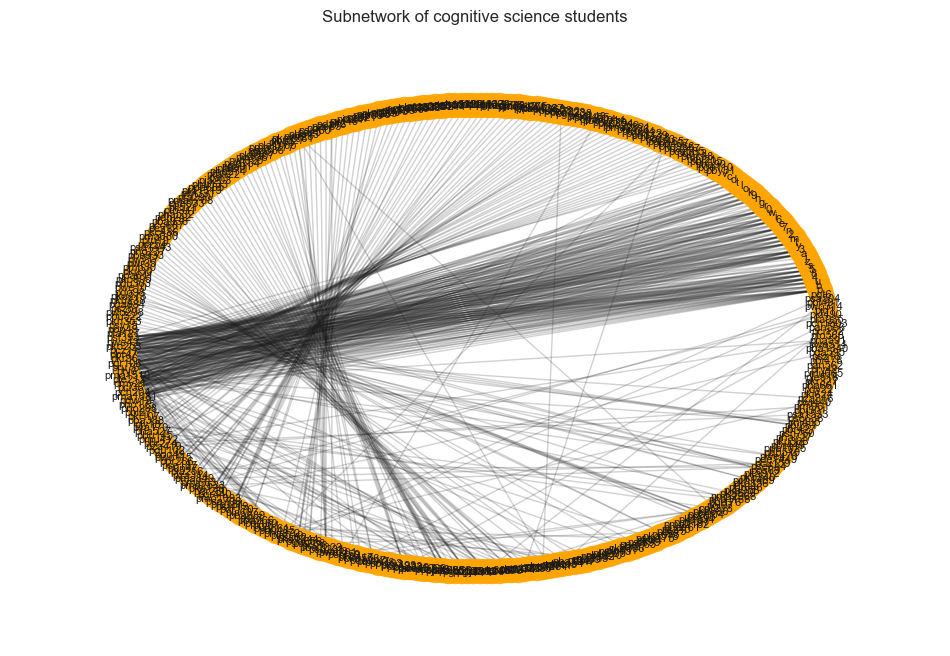

In [95]:
# shell layout

pos = nx.shell_layout(G)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=300, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# DRAW LABELS
nx.draw_networkx_labels(G, pos, font_size=8)

# Adjust plot margins
plt.margins(0.1, 0.1)

# remove a frame
plt.axis('off')

plt.title("Subnetwork of cognitive science students")
plt.show()

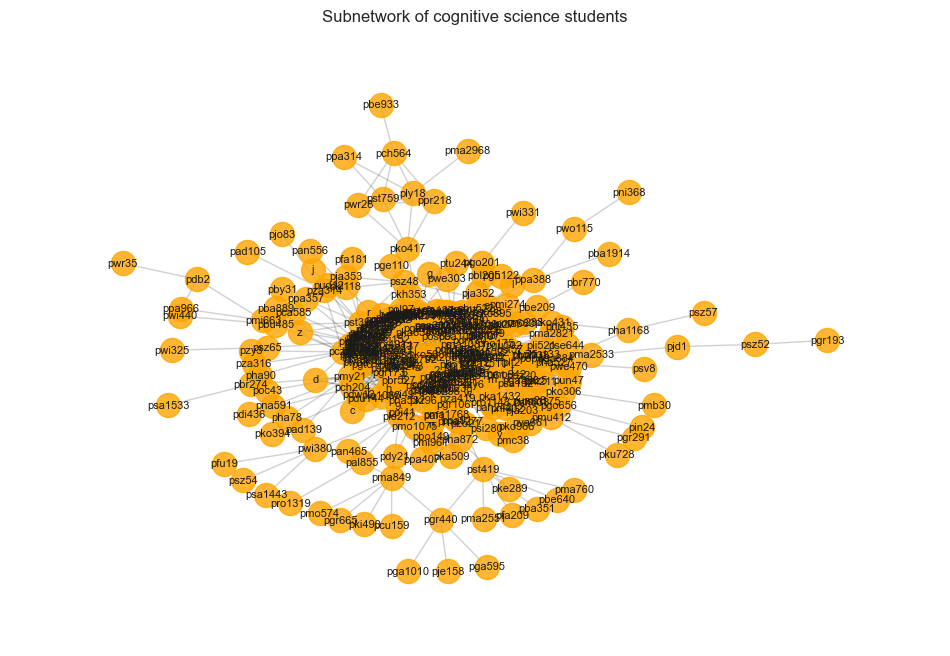

In [94]:
#kamada_kawai_layout - I think looks promising

pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=300, alpha=0.8)
# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# DRAW LABELS
nx.draw_networkx_labels(G, pos, font_size=8)


plt.title("Subnetwork of cognitive science students")

# remove a frame
plt.axis('off')

# Adjust plot margins
plt.margins(0.1, 0.1)

plt.show()

In [97]:
density = nx.density(G)
print("Network density:", density * 100)
# 0.8% of all possible connections is achieved via network

Network density: 0.7904357276948918


In [ ]:
# Social Networks
# Czy osoby wewnątrz instytucji są ze sobą bardziej usieciowienie?
# Czy dla kohort, które zaczęły pracę w latach 200-2025, współpraca z autorem z top 10 miejsc z listy jest powiązana z indywidualną wysoką pozycją?